Notebook to investigate raw FinBERT predictions (excluding results of Granger Causality & OLS, see \notebooks\exploratory_analysis_regression_results.ipnyb)

In [50]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import re
import itertools
import datetime as dt
import sqlite3
from collections import defaultdict
from functools import reduce
from IPython.display import display, HTML
# connect to folder for custom functions
root = Path.cwd().parent
vis_path = root / "src" / "visualizations" 
mod_path = root / "src" / "modelling" 
sys.path.append(str(vis_path))
sys.path.append(str(mod_path))

from read_articles import read, investigate_hype_articles
from plot_functions import plot_aini_means_three_panels, plot_aini_hist_grid_by_years, plot_timeline, plot_n_articles_with_extrema_events
from compute_extrema import compute_aini_extrema
from calculate_summary_statistics import calculate_aini_statistics

In [2]:
# prepare paths
var_path = root / "data" / "processed" / "variables"
art_path = root / "data" / "processed" / "articles"
table_path = root / "reports" / "tables"
fig_path = root / "reports" / "figures"

# load aini data
aini_custom = pd.read_csv(var_path / "binary_AINI_variables.csv")
aini_w0 = pd.read_csv(var_path / "w0_AINI_variables.csv")
aini_w1 = pd.read_csv(var_path / "w1_AINI_variables.csv")
aini_w2 =  pd.read_csv(var_path / "w2_AINI_variables.csv")

In [3]:
# read out total n of articles
years = ["2023","2024","2025"]
query = "SELECT * FROM ARTICLE"
final_df = pd.DataFrame()

for year in years:
    db_path = art_path / f"articlesWSJ_clean_{year}.db"
    con = sqlite3.connect(str(db_path))
    df = pd.read_sql(query, con)
    con.close()
    final_df = pd.concat([final_df, df], ignore_index=True)

aini_w2

date  normalized_AINI  simple_AINI    EMA_02    EMA_08
0    2023-04-01              0.0            0  0.000000  0.000000
1    2023-04-02              0.0            0  0.000000  0.000000
2    2023-04-03              0.0            0  0.000000  0.000000
3    2023-04-04              0.0            0  0.000000  0.000000
4    2023-04-05              0.0            0  0.000000  0.000000
..          ...              ...          ...       ...       ...
776  2025-06-12              0.0            0  0.047604  0.013605
777  2025-06-13              0.1            3  0.058083  0.082721
778  2025-06-14              0.0            0  0.046467  0.016544
779  2025-06-15              0.0            0  0.037173  0.003309
780  2025-06-16              0.2            3  0.069739  0.160662

[781 rows x 5 columns]

In [4]:
# ensure format
final_df["date"] = pd.to_datetime(final_df["date"])

# extract year
final_df["year"] = final_df["date"].dt.year

# analyze discriptes 
grouped = final_df.groupby("year")

grouped.describe()

article_id                                                               \
          count          mean      min       25%      50%       75%      max   
year                                                                           
2023     4401.0   4539.958646     36.0   1811.00   4557.0   6977.00   9103.0   
2024    14443.0  24358.353320  13068.0  18219.50  23148.0  30328.50  37460.0   
2025     4060.0   2063.363054      1.0   1033.75   2063.5   3095.25   4124.0   

                  index_id                ...       id                date  \
              std    count          mean  ...      max          std  count   
year                                      ...                                
2023  2778.962386   4401.0   5351.867076  ...   9103.0  2502.711422   4401   
2024  7177.174746  14443.0  14078.117773  ...  27490.0  8821.058835  14443   
2025  1190.751588   4060.0   2255.603941  ...   4910.0  1459.880677   4060   

                                                                               \
                               mean                  min                  25%   
year                                                                            
2023  2023-08-04 22:45:43.558282240  2023-01-03 00:00:00  2023-05-16 00:00:00   
2024  2024-07-07 02:52:35.078584832  2024-01-01 00:00:00  2024-03-16 00:00:00   
2025  2025-03-18 01:20:30.738916352  2025-01-01 00:00:00  2025-02-05 00:00:00   

                                                                          
                      50%                  75%                  max  std  
year                                                                      
2023  2023-07-27 00:00:00  2023-11-03 00:00:00  2023-12-31 00:00:00  NaN  
2024  2024-07-09 00:00:00  2024-10-30 00:00:00  2024-12-31 00:00:00  NaN  
2025  2025-03-11 00:00:00  2025-04-15 00:00:00  2025-06-16 00:00:00  NaN  

[3 rows x 32 columns]

In [80]:
# create dataframes for visualizaions
normalized_AINI = pd.DataFrame()

# ensure sorting
aini_w0 = aini_w0.sort_values("date")
aini_w1 = aini_w1.sort_values("date")
aini_w2 = aini_w2.sort_values("date")
aini_custom = aini_custom.sort_values("date")

# compute extrema; exclude noisy dates & 0 AINI vals
merged, tidy, pivot, extrema = compute_aini_extrema(aini_w0,aini_w1,aini_w2,aini_custom,
                                                    exclude_dates=["2023-07-15","2023-06-30","2023-04-01","2023-04-02"])
merged

c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_nonzero[value_cols] = merged_nonzero[value_cols].apply(pd.to_numeric, errors="coerce")
c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:145: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tidy.pivot_table(
c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

date  normalized_AINI_w0  simple_AINI_w0  EMA_02_w0  EMA_08_w0  \
2   2023-04-03            0.000000               0   0.000000   0.000000   
3   2023-04-04            0.000000               0   0.000000   0.000000   
4   2023-04-05            0.000000               0   0.000000   0.000000   
5   2023-04-06            0.000000               0   0.000000   0.000000   
6   2023-04-07            0.000000               0   0.000000   0.000000   
..         ...                 ...             ...        ...        ...   
776 2025-06-12            0.000000               0   0.043486   0.014145   
777 2025-06-13            0.033333               1   0.041456   0.029496   
778 2025-06-14            0.000000               0   0.033164   0.005899   
779 2025-06-15            0.000000               0   0.026532   0.001180   
780 2025-06-16            0.133333               2   0.047892   0.106903   

     normalized_AINI_w1  simple_AINI_w1  EMA_02_w1  EMA_08_w1  \
2              0.000000               0   0.000000   0.000000   
3              0.000000               0   0.000000   0.000000   
4              0.000000               0   0.000000   0.000000   
5              0.000000               0   0.000000   0.000000   
6              0.000000               0   0.000000   0.000000   
..                  ...             ...        ...        ...   
776            0.000000               0   0.035155   0.010033   
777            0.100000               3   0.048124   0.082007   
778            0.000000               0   0.038499   0.016401   
779            0.000000               0   0.030799   0.003280   
780            0.133333               2   0.051306   0.107323   

     normalized_AINI_w2  simple_AINI_w2  EMA_02_w2  EMA_08_w2  \
2                   0.0               0   0.000000   0.000000   
3                   0.0               0   0.000000   0.000000   
4                   0.0               0   0.000000   0.000000   
5                   0.0               0   0.000000   0.000000   
6                   0.0               0   0.000000   0.000000   
..                  ...             ...        ...        ...   
776                 0.0               0   0.047604   0.013605   
777                 0.1               3   0.058083   0.082721   
778                 0.0               0   0.046467   0.016544   
779                 0.0               0   0.037173   0.003309   
780                 0.2               3   0.069739   0.160662   

     normalized_AINI_custom  simple_AINI_custom  EMA_02_custom  EMA_08_custom  
2                  0.000000                   0       0.000000       0.000000  
3                  0.000000                   0       0.000000       0.000000  
4                  0.000000                   0       0.000000       0.000000  
5                 -0.076923                  -1      -0.015385      -0.061538  
6                  0.000000                   0      -0.012308      -0.012308  
..                      ...                 ...            ...            ...  
776               -0.055556                  -2      -0.098190      -0.049539  
777               -0.166667                  -5      -0.111886      -0.143241  
778                0.000000                   0      -0.089509      -0.028648  
779                0.000000                   0      -0.071607      -0.005730  
780               -0.066667                  -1      -0.070619      -0.054479  

[777 rows x 17 columns]

In [81]:
# compute autocorr
cols = ["EMA_02_w0", "EMA_02_w1", "EMA_02_custom"]

merged = merged.copy()
merged["date"] = pd.to_datetime(merged["date"])
merged = merged.sort_values("date")

def acfs(df, cols, lags=(1, 2, 3)):
    rows = []
    for c in cols:
        s = df[c].dropna()
        for k in lags:
            rows.append({"Measure": c, "lag": k, "acf": s.autocorr(lag=k)})
    return pd.DataFrame(rows)

periods = {
    "2023-2025": ("2023-01-01", "2025-12-31"),
    "2025": ("2025-01-01", "2025-12-31"),
    "2023-2024": ("2023-01-01", "2024-12-31"),
}

results = []
for name, (start, end) in periods.items():
    m = merged[(merged["date"] >= start) & (merged["date"] <= end)]
    df = acfs(m, cols)
    df["Period"] = name
    results.append(df)

acfs_df = (
    pd.concat(results, ignore_index=True)
    .loc[:, ["Period", "Measure", "lag", "acf"]]
    .sort_values(["Period", "Measure", "lag"])
)

print(acfs_df)

       Period        Measure  lag       acf
24  2023-2024  EMA_02_custom    1  0.865984
25  2023-2024  EMA_02_custom    2  0.717360
26  2023-2024  EMA_02_custom    3  0.591355
18  2023-2024      EMA_02_w0    1  0.799329
19  2023-2024      EMA_02_w0    2  0.653991
20  2023-2024      EMA_02_w0    3  0.553495
21  2023-2024      EMA_02_w1    1  0.830532
22  2023-2024      EMA_02_w1    2  0.697682
23  2023-2024      EMA_02_w1    3  0.593574
6   2023-2025  EMA_02_custom    1  0.884123
7   2023-2025  EMA_02_custom    2  0.748385
8   2023-2025  EMA_02_custom    3  0.623953
0   2023-2025      EMA_02_w0    1  0.870156
1   2023-2025      EMA_02_w0    2  0.767527
2   2023-2025      EMA_02_w0    3  0.691066
3   2023-2025      EMA_02_w1    1  0.909787
4   2023-2025      EMA_02_w1    2  0.826172
5   2023-2025      EMA_02_w1    3  0.757778
15       2025  EMA_02_custom    1  0.923142
16       2025  EMA_02_custom    2  0.808825
17       2025  EMA_02_custom    3  0.678830
9        2025      EMA_02_w0    

In [6]:
# show extrema
extrema.sort_values("n measures",ascending=False)

type        date  n measures  \
0   minimum  2025-02-06           3   
14  maximum  2025-06-16           3   
13  maximum  2025-06-07           3   
3   minimum  2025-01-28           2   
1   minimum  2023-08-13           2   
15  maximum  2025-06-10           2   
4   minimum  2025-01-31           2   
2   minimum  2024-08-02           2   
17  maximum  2023-09-07           1   
18  maximum  2024-10-10           1   
5   minimum  2025-01-20           1   
16  maximum  2023-04-09           1   
19  maximum  2025-03-22           1   
24  maximum  2025-01-31           0   
23  maximum  2025-01-28           0   
22  maximum  2025-01-20           0   
21  maximum  2024-08-02           0   
20  maximum  2023-08-13           0   
8   minimum  2024-10-10           0   
9   minimum  2025-03-22           0   
6   minimum  2023-04-09           0   
7   minimum  2023-09-07           0   
12  minimum  2025-06-16           0   
11  minimum  2025-06-10           0   
10  minimum  2025-06-07           0   
25  maximum  2025-02-06           0   

                                              measure  
0   normalized_AINI_custom, EMA_02_custom, EMA_08_...  
14           normalized_AINI_w2, EMA_02_w2, EMA_08_w2  
13           normalized_AINI_w0, EMA_02_w0, EMA_08_w0  
3                       normalized_AINI_w1, EMA_08_w1  
1                       normalized_AINI_w0, EMA_08_w0  
15                      normalized_AINI_w1, EMA_08_w1  
4                                EMA_02_w1, EMA_02_w2  
2                       normalized_AINI_w2, EMA_08_w2  
17                                      EMA_08_custom  
18                             normalized_AINI_custom  
5                                           EMA_02_w0  
16                                      EMA_02_custom  
19                                          EMA_02_w1  
24                                                     
23                                                     
22                                                     
21                                                     
20                                                     
8                                                      
9                                                      
6                                                      
7                                                      
12                                                     
11                                                     
10                                                     
25

Explore differences in min, max, mean and std. of AINI variables

In [7]:
stats = calculate_aini_statistics(merged)
stats.to_html(table_path / "AINI_summary_statistics.html")
stats

scope            variable  count      mean       std        min    median  \
0   Total       EMA_02_custom    777 -0.087874  0.031707  -0.284651 -0.086383   
1   Total           EMA_02_w0    777 -0.000685  0.019074  -0.068745  0.000072   
2   Total           EMA_02_w1    777 -0.004583  0.023217  -0.109569 -0.002466   
3   Total           EMA_02_w2    777 -0.005780  0.022230  -0.097269 -0.003288   
4   Total       EMA_08_custom    777 -0.087730  0.063610  -0.456777 -0.081409   
..    ...                 ...    ...       ...       ...        ...       ...   
59   2025  normalized_AINI_w2    141  0.000121  0.069441  -0.208333  0.000000   
60   2025  simple_AINI_custom    141 -3.106383  3.600996 -26.000000 -2.000000   
61   2025      simple_AINI_w0    141  0.141844  1.895791  -5.000000  0.000000   
62   2025      simple_AINI_w1    141  0.078014  2.324008  -8.000000  0.000000   
63   2025      simple_AINI_w2    141  0.106383  2.123683  -7.000000  0.000000   

         max  
0   0.000000  
1   0.058285  
2   0.057163  
3   0.069739  
4   0.000000  
..       ...  
59  0.200000  
60  0.000000  
61  7.000000  
62  8.000000  
63  6.000000  

[64 rows x 8 columns]

In [ ]:
merged

Index(['article_id', 'image_src_custom', 'scanned_time_custom', 'title_custom',
       'sub_title_custom', 'corpus_custom', 'index_id_custom', 'id_custom',
       'date_custom', 'link_custom', 'section_custom', 'cleaned_corpus_custom',
       'ai_window_custom', 'predicted_label_custom', 'predicted_class_custom',
       'ai_relevant_custom', 'sentiment_label_custom',
       'sentiment_score_custom', 'hype_score_custom', 'image_src_w0',
       'scanned_time_w0', 'title_w0', 'sub_title_w0', 'corpus_w0',
       'index_id_w0', 'id_w0', 'date_w0', 'link_w0', 'section_w0',
       'cleaned_corpus_w0', 'text_w0', 'ai_window_w0', 'ai_relevant_w0',
       'sentiment_label_w0', 'sentiment_score_w0', 'hype_score_w0',
       'image_src_w1', 'scanned_time_w1', 'title_w1', 'sub_title_w1',
       'corpus_w1', 'index_id_w1', 'id_w1', 'date_w1', 'link_w1', 'section_w1',
       'cleaned_corpus_w1', 'text_w1', 'ai_window_w1', 'ai_relevant_w1',
       'sentiment_label_w1', 'sentiment_score_w1', 'hype_score

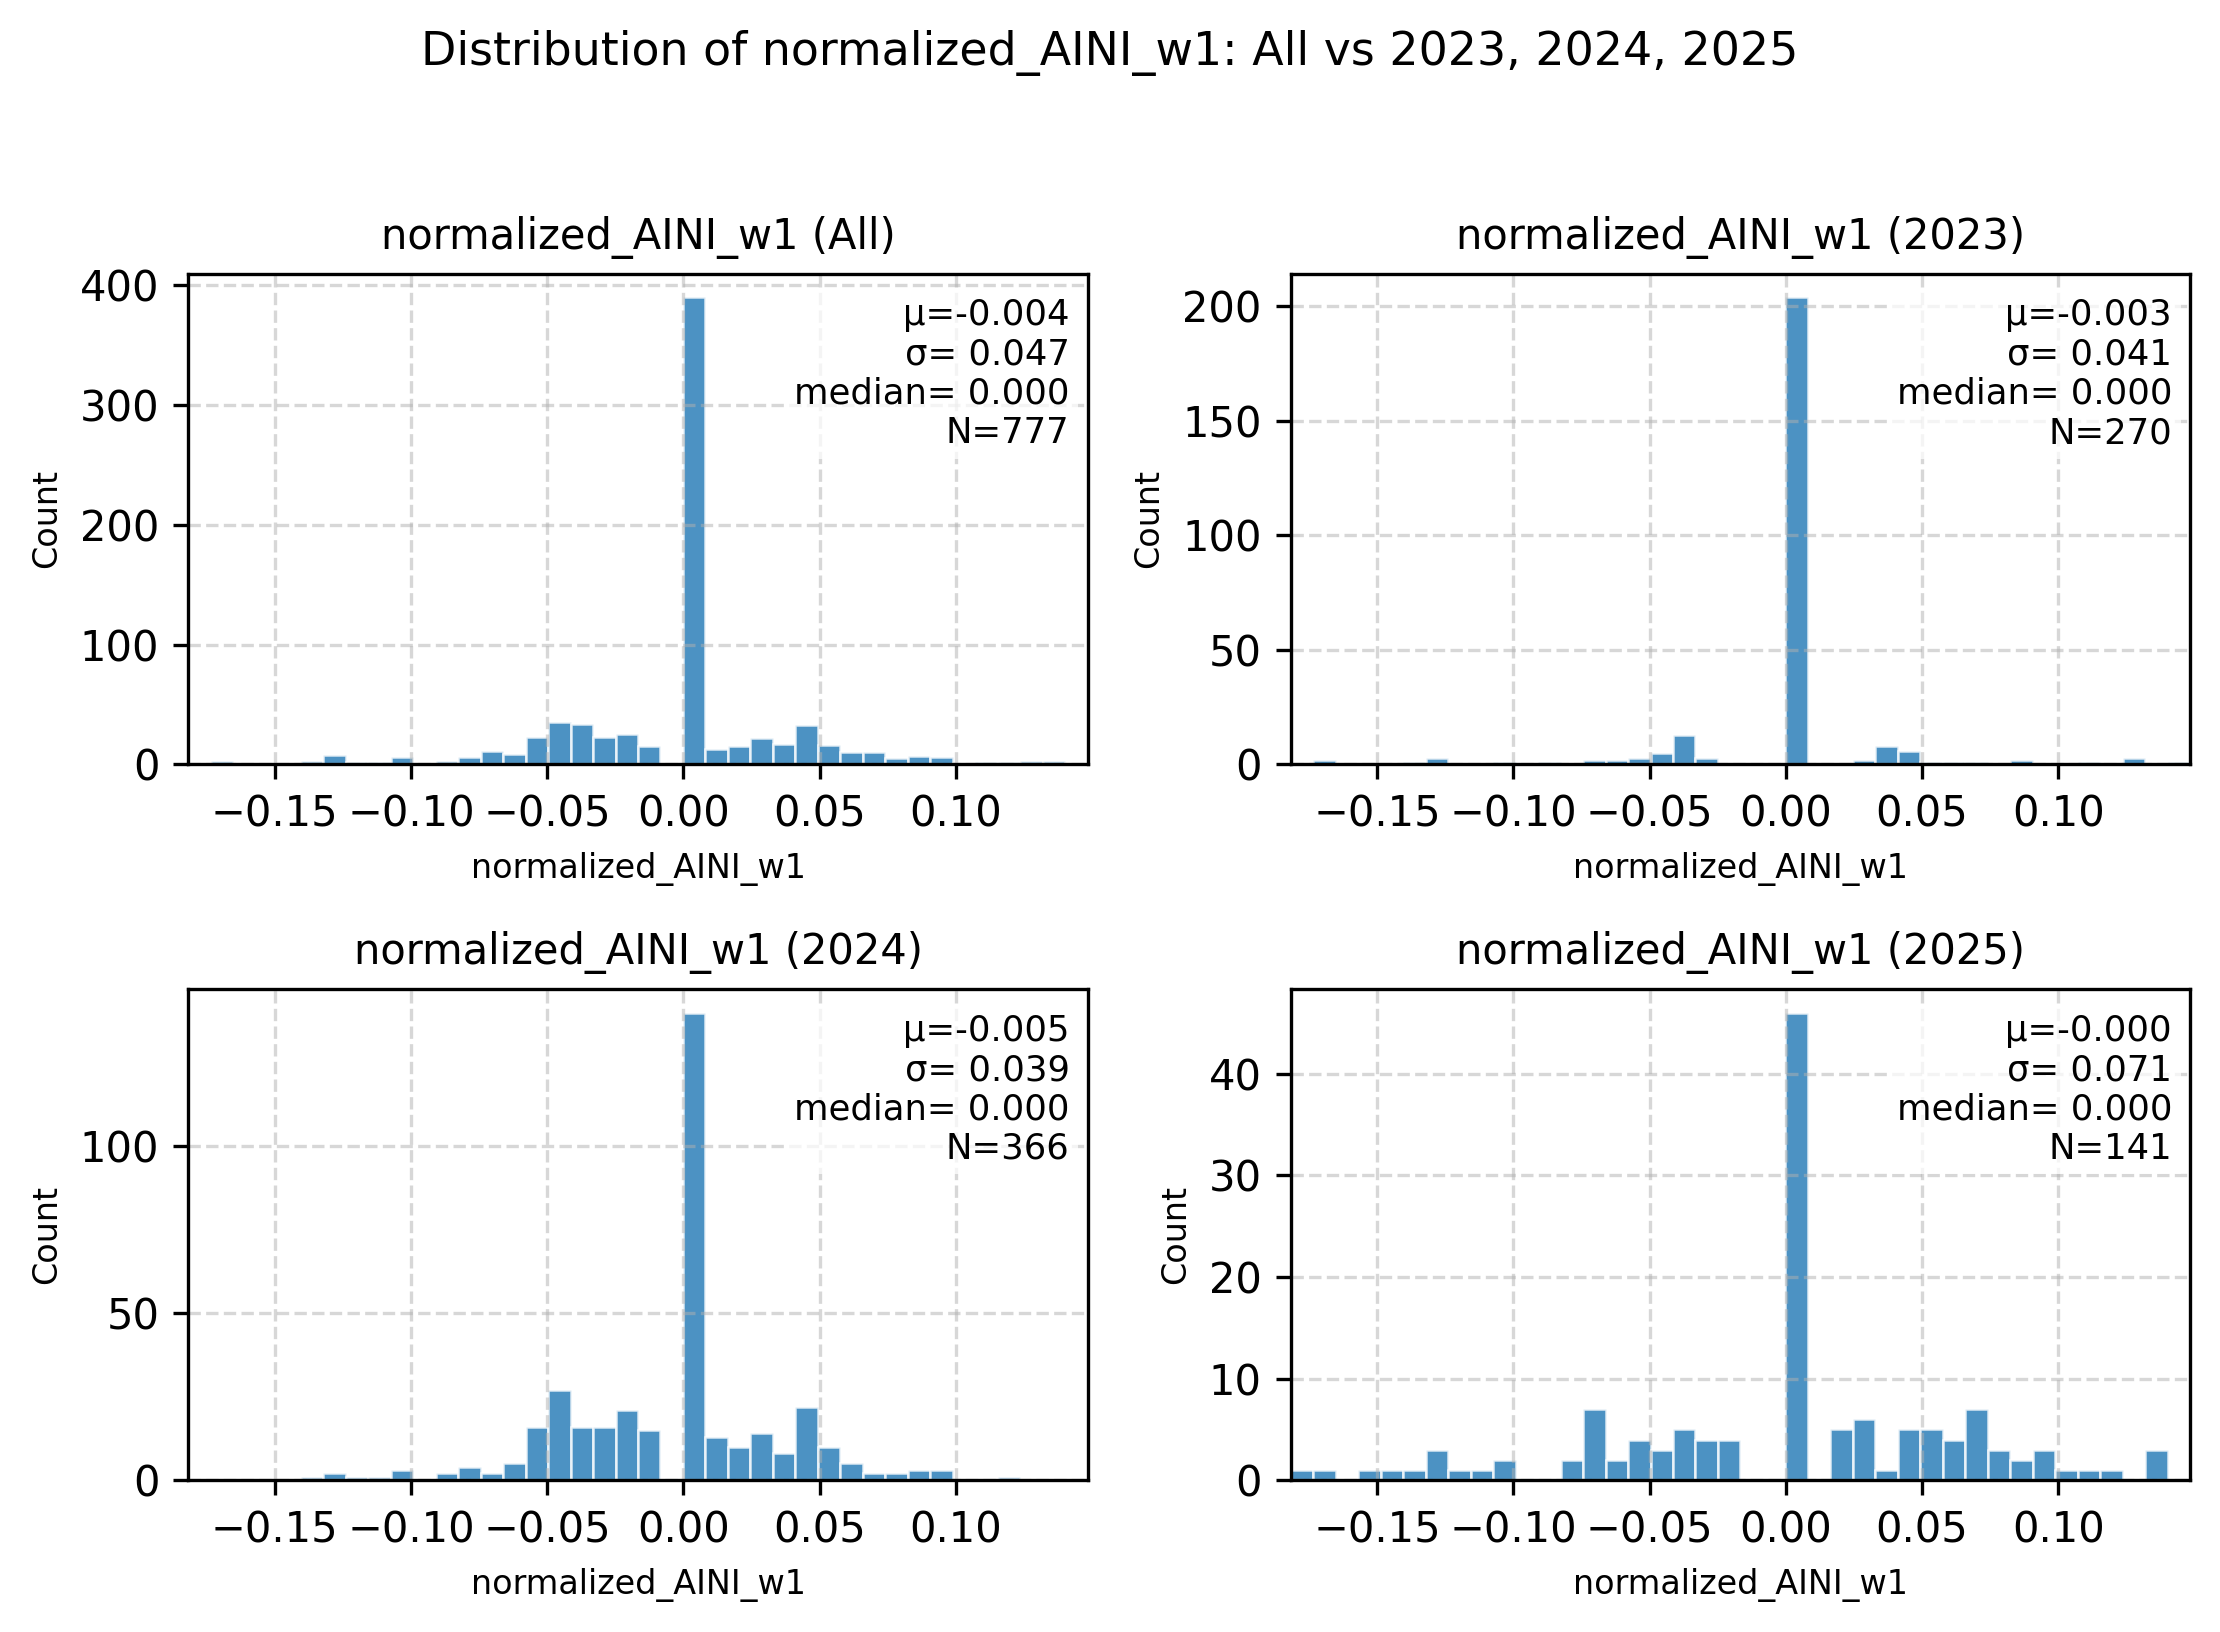

date  normalized_AINI_w0  simple_AINI_w0  EMA_02_w0  EMA_08_w0  \
2   2023-04-03            0.000000               0   0.000000   0.000000   
3   2023-04-04            0.000000               0   0.000000   0.000000   
4   2023-04-05            0.000000               0   0.000000   0.000000   
5   2023-04-06            0.000000               0   0.000000   0.000000   
6   2023-04-07            0.000000               0   0.000000   0.000000   
..         ...                 ...             ...        ...        ...   
776 2025-06-12            0.000000               0   0.043486   0.014145   
777 2025-06-13            0.033333               1   0.041456   0.029496   
778 2025-06-14            0.000000               0   0.033164   0.005899   
779 2025-06-15            0.000000               0   0.026532   0.001180   
780 2025-06-16            0.133333               2   0.047892   0.106903   

     normalized_AINI_w1  simple_AINI_w1  EMA_02_w1  EMA_08_w1  \
2              0.000000               0   0.000000   0.000000   
3              0.000000               0   0.000000   0.000000   
4              0.000000               0   0.000000   0.000000   
5              0.000000               0   0.000000   0.000000   
6              0.000000               0   0.000000   0.000000   
..                  ...             ...        ...        ...   
776            0.000000               0   0.035155   0.010033   
777            0.100000               3   0.048124   0.082007   
778            0.000000               0   0.038499   0.016401   
779            0.000000               0   0.030799   0.003280   
780            0.133333               2   0.051306   0.107323   

     normalized_AINI_w2  simple_AINI_w2  EMA_02_w2  EMA_08_w2  \
2                   0.0               0   0.000000   0.000000   
3                   0.0               0   0.000000   0.000000   
4                   0.0               0   0.000000   0.000000   
5                   0.0               0   0.000000   0.000000   
6                   0.0               0   0.000000   0.000000   
..                  ...             ...        ...        ...   
776                 0.0               0   0.047604   0.013605   
777                 0.1               3   0.058083   0.082721   
778                 0.0               0   0.046467   0.016544   
779                 0.0               0   0.037173   0.003309   
780                 0.2               3   0.069739   0.160662   

     normalized_AINI_custom  simple_AINI_custom  EMA_02_custom  EMA_08_custom  
2                  0.000000                   0       0.000000       0.000000  
3                  0.000000                   0       0.000000       0.000000  
4                  0.000000                   0       0.000000       0.000000  
5                 -0.076923                  -1      -0.015385      -0.061538  
6                  0.000000                   0      -0.012308      -0.012308  
..                      ...                 ...            ...            ...  
776               -0.055556                  -2      -0.098190      -0.049539  
777               -0.166667                  -5      -0.111886      -0.143241  
778                0.000000                   0      -0.089509      -0.028648  
779                0.000000                   0      -0.071607      -0.005730  
780               -0.066667                  -1      -0.070619      -0.054479  

[777 rows x 17 columns]

In [8]:
# plot distribution, ignoring raw counts due to unequal count of articles / day
outpath_hist = fig_path / "aini_hist_w1_panels.png"

plot_aini_hist_grid_by_years(
            df = merged,
            outpath= outpath_hist
        )
merged

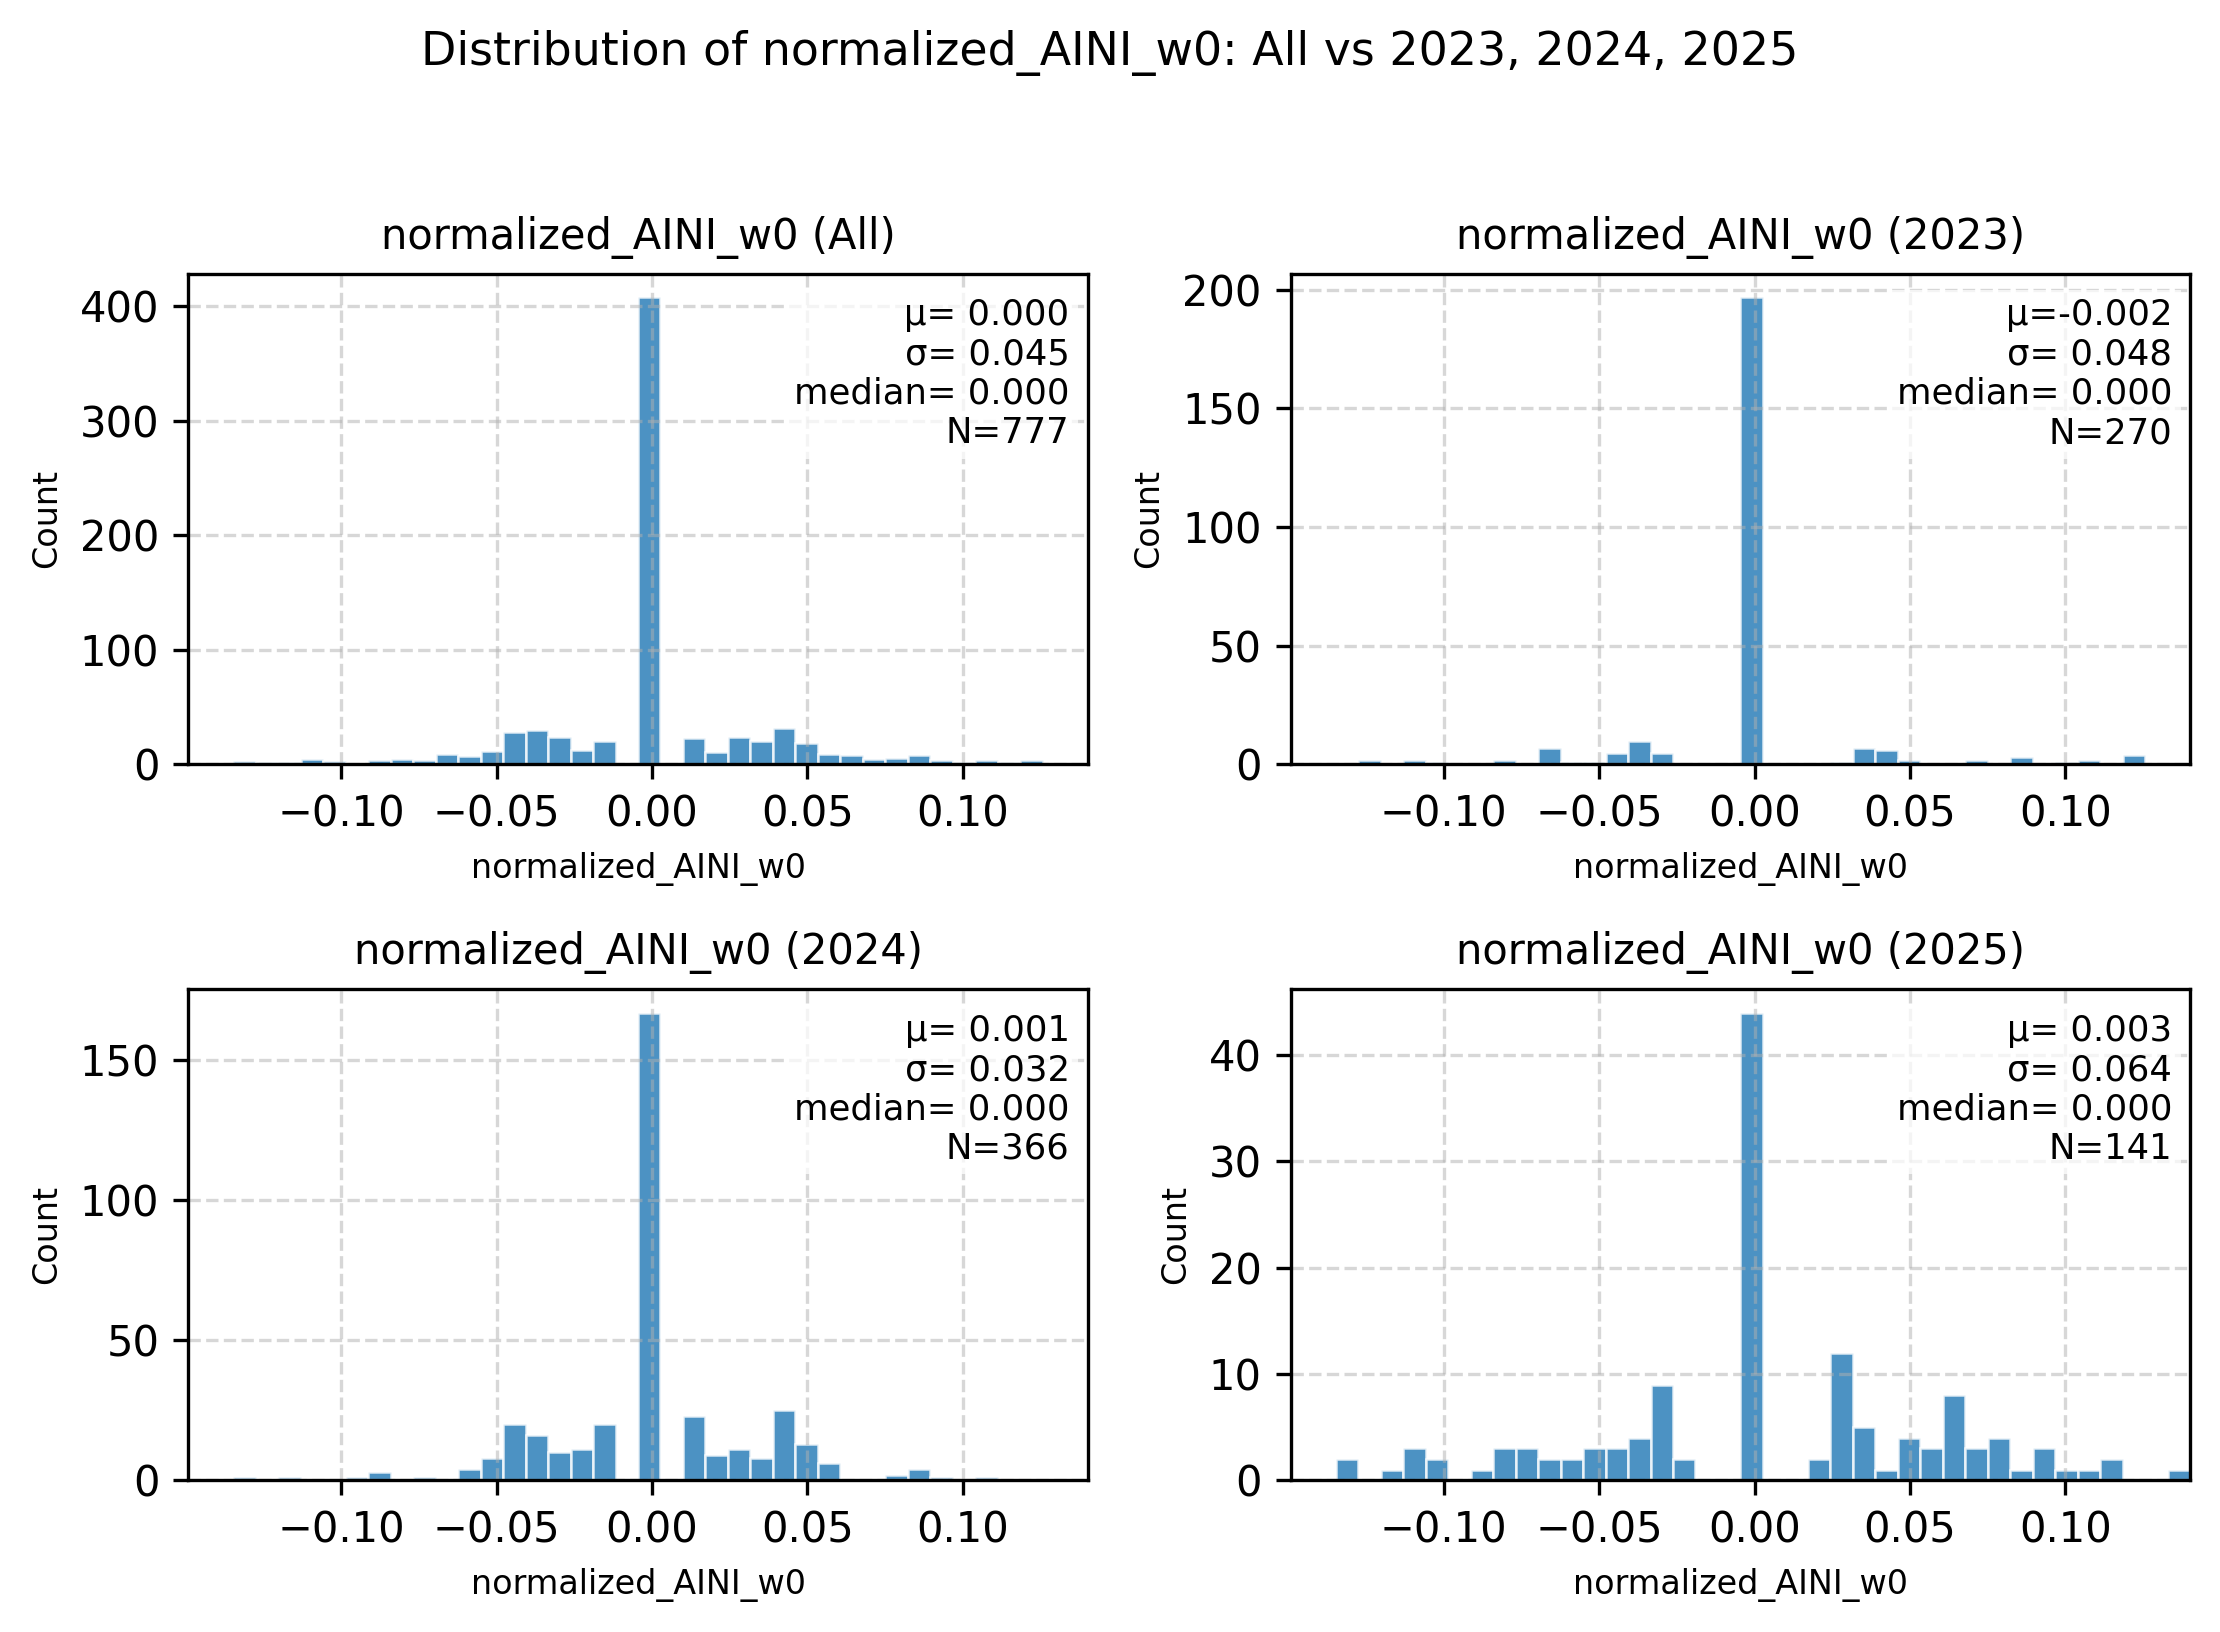

In [9]:
# plot distribution, ignoring raw counts due to unequal count of articles / day
outpath_hist = fig_path / "aini_hist_w0_panels.png"

plot_aini_hist_grid_by_years(
            df = merged,
            measure="normalized_AINI_w0",
            outpath= outpath_hist
        )

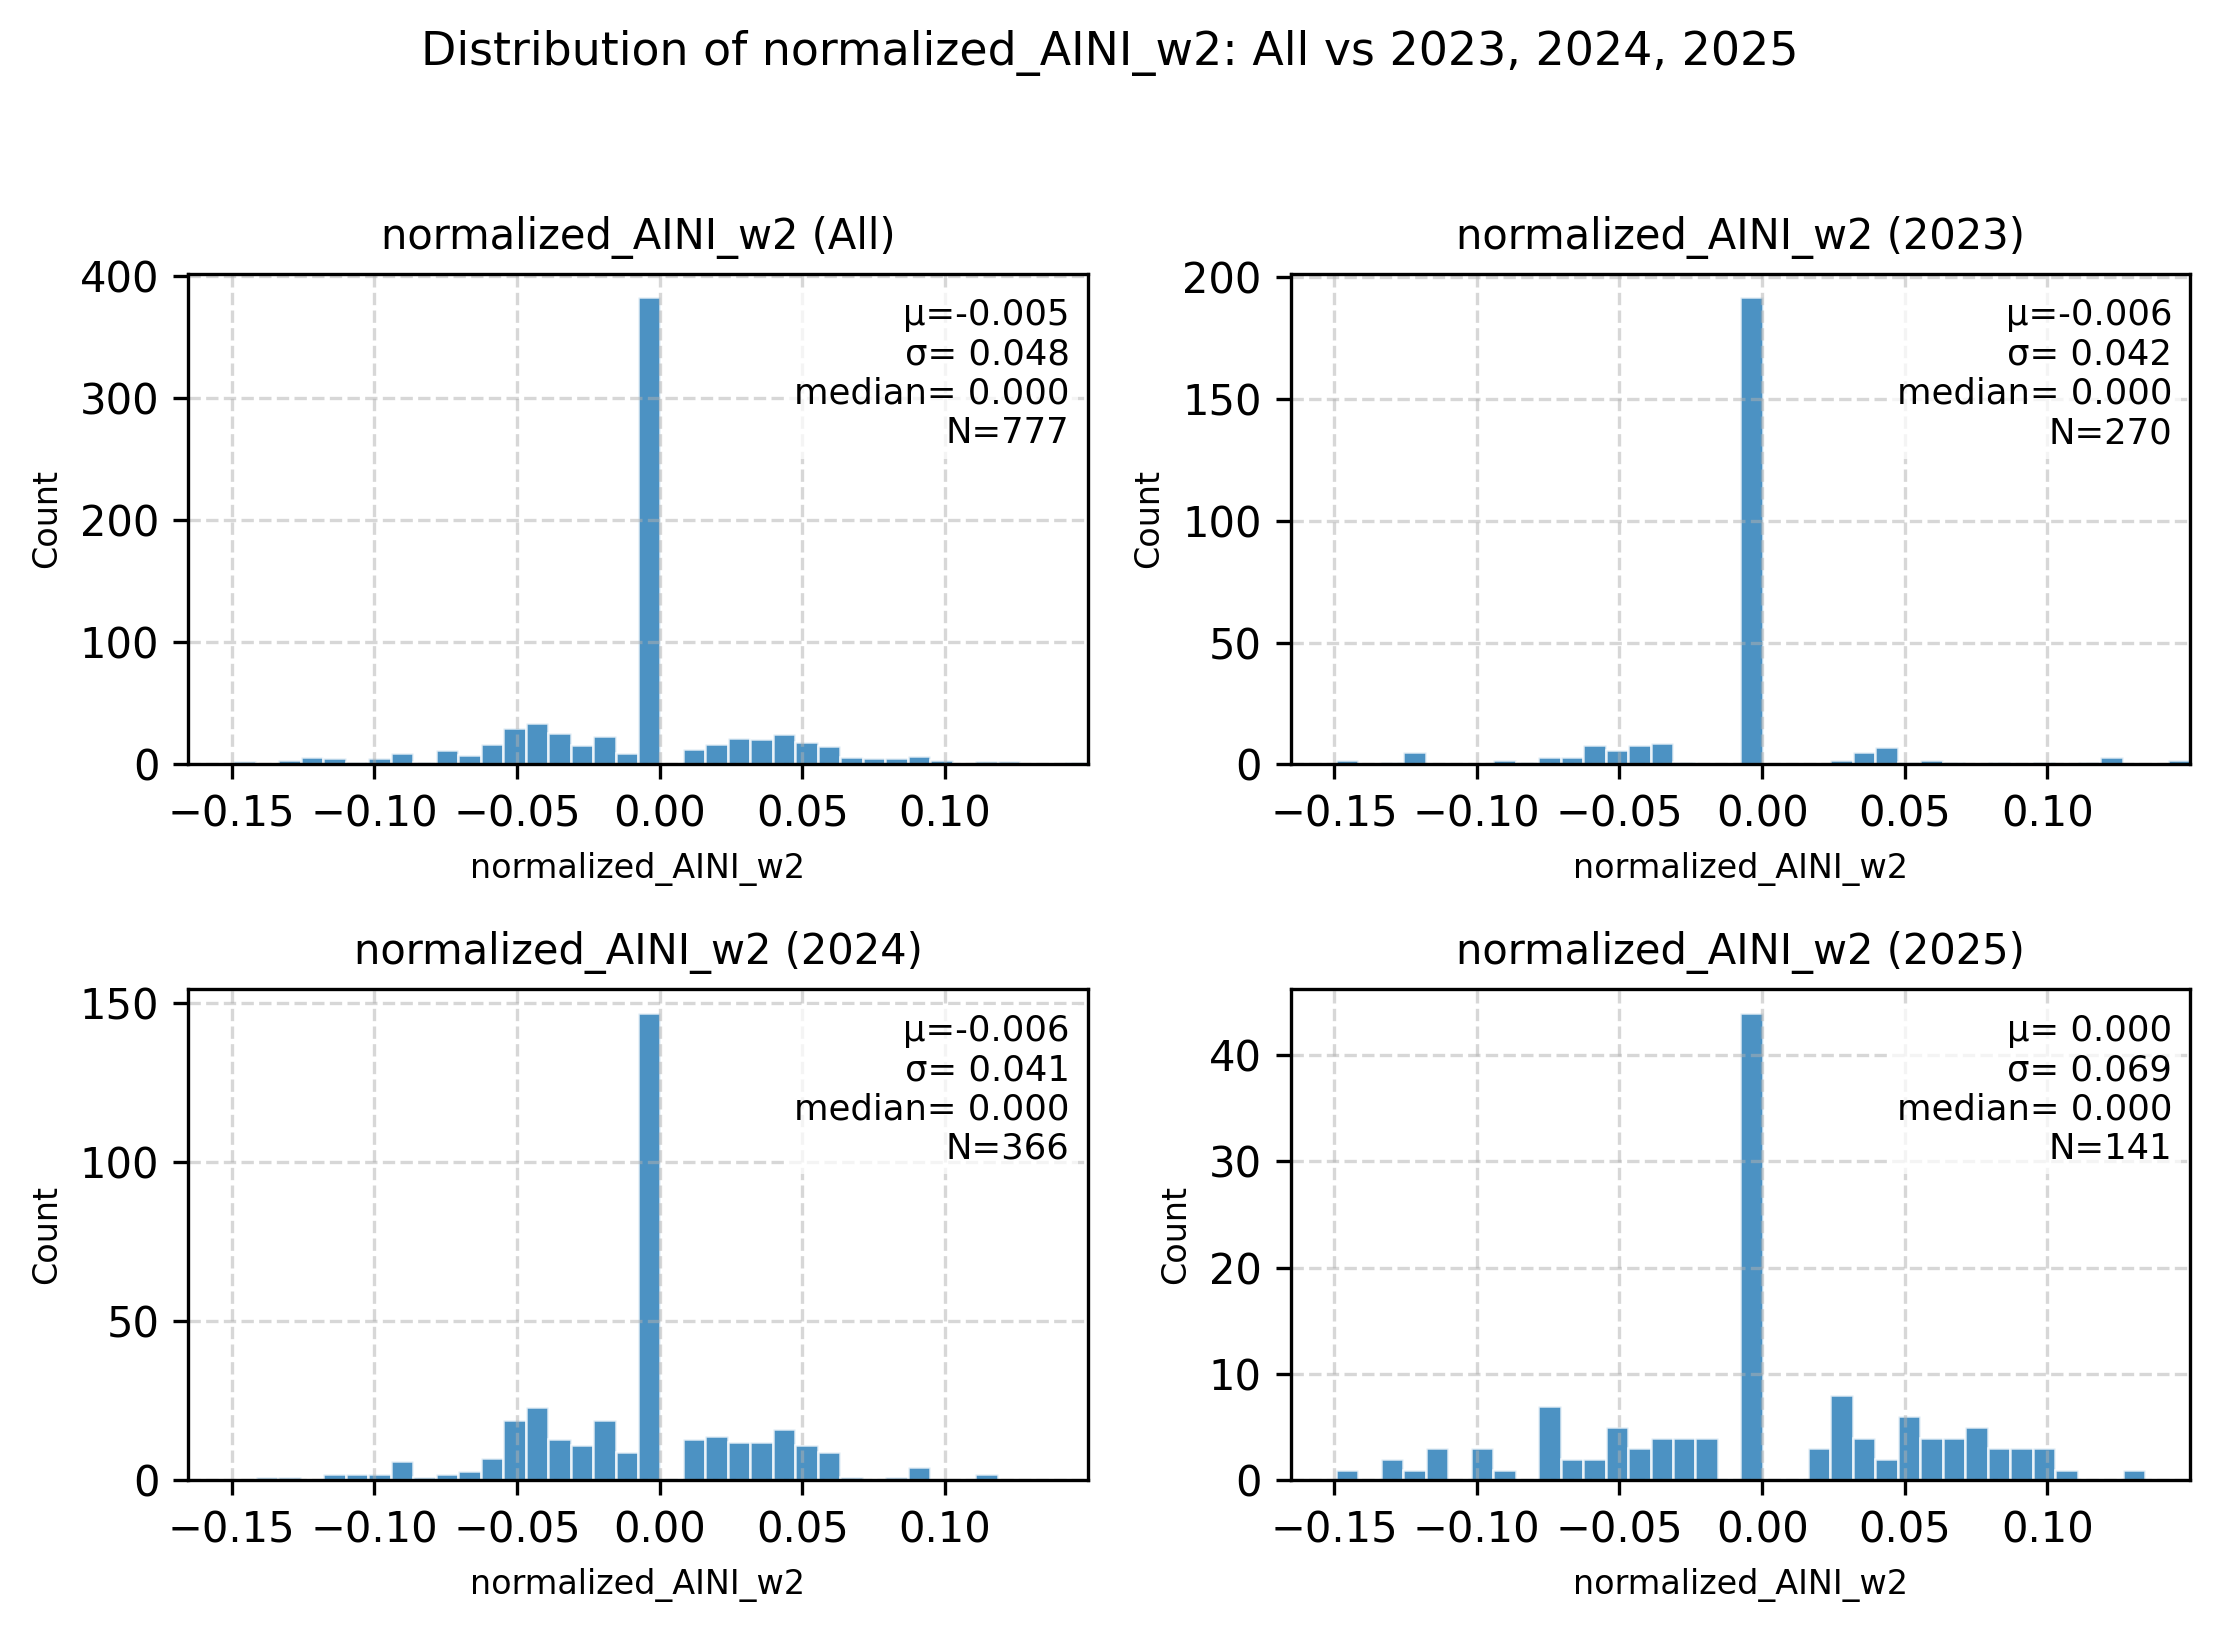

In [10]:
# plot distribution, ignoring raw counts due to unequal count of articles / day
outpath_hist = fig_path / "aini_hist_w2_panels.png"

plot_aini_hist_grid_by_years(
            df = merged,
            measure="normalized_AINI_w2",
            outpath= outpath_hist
        )

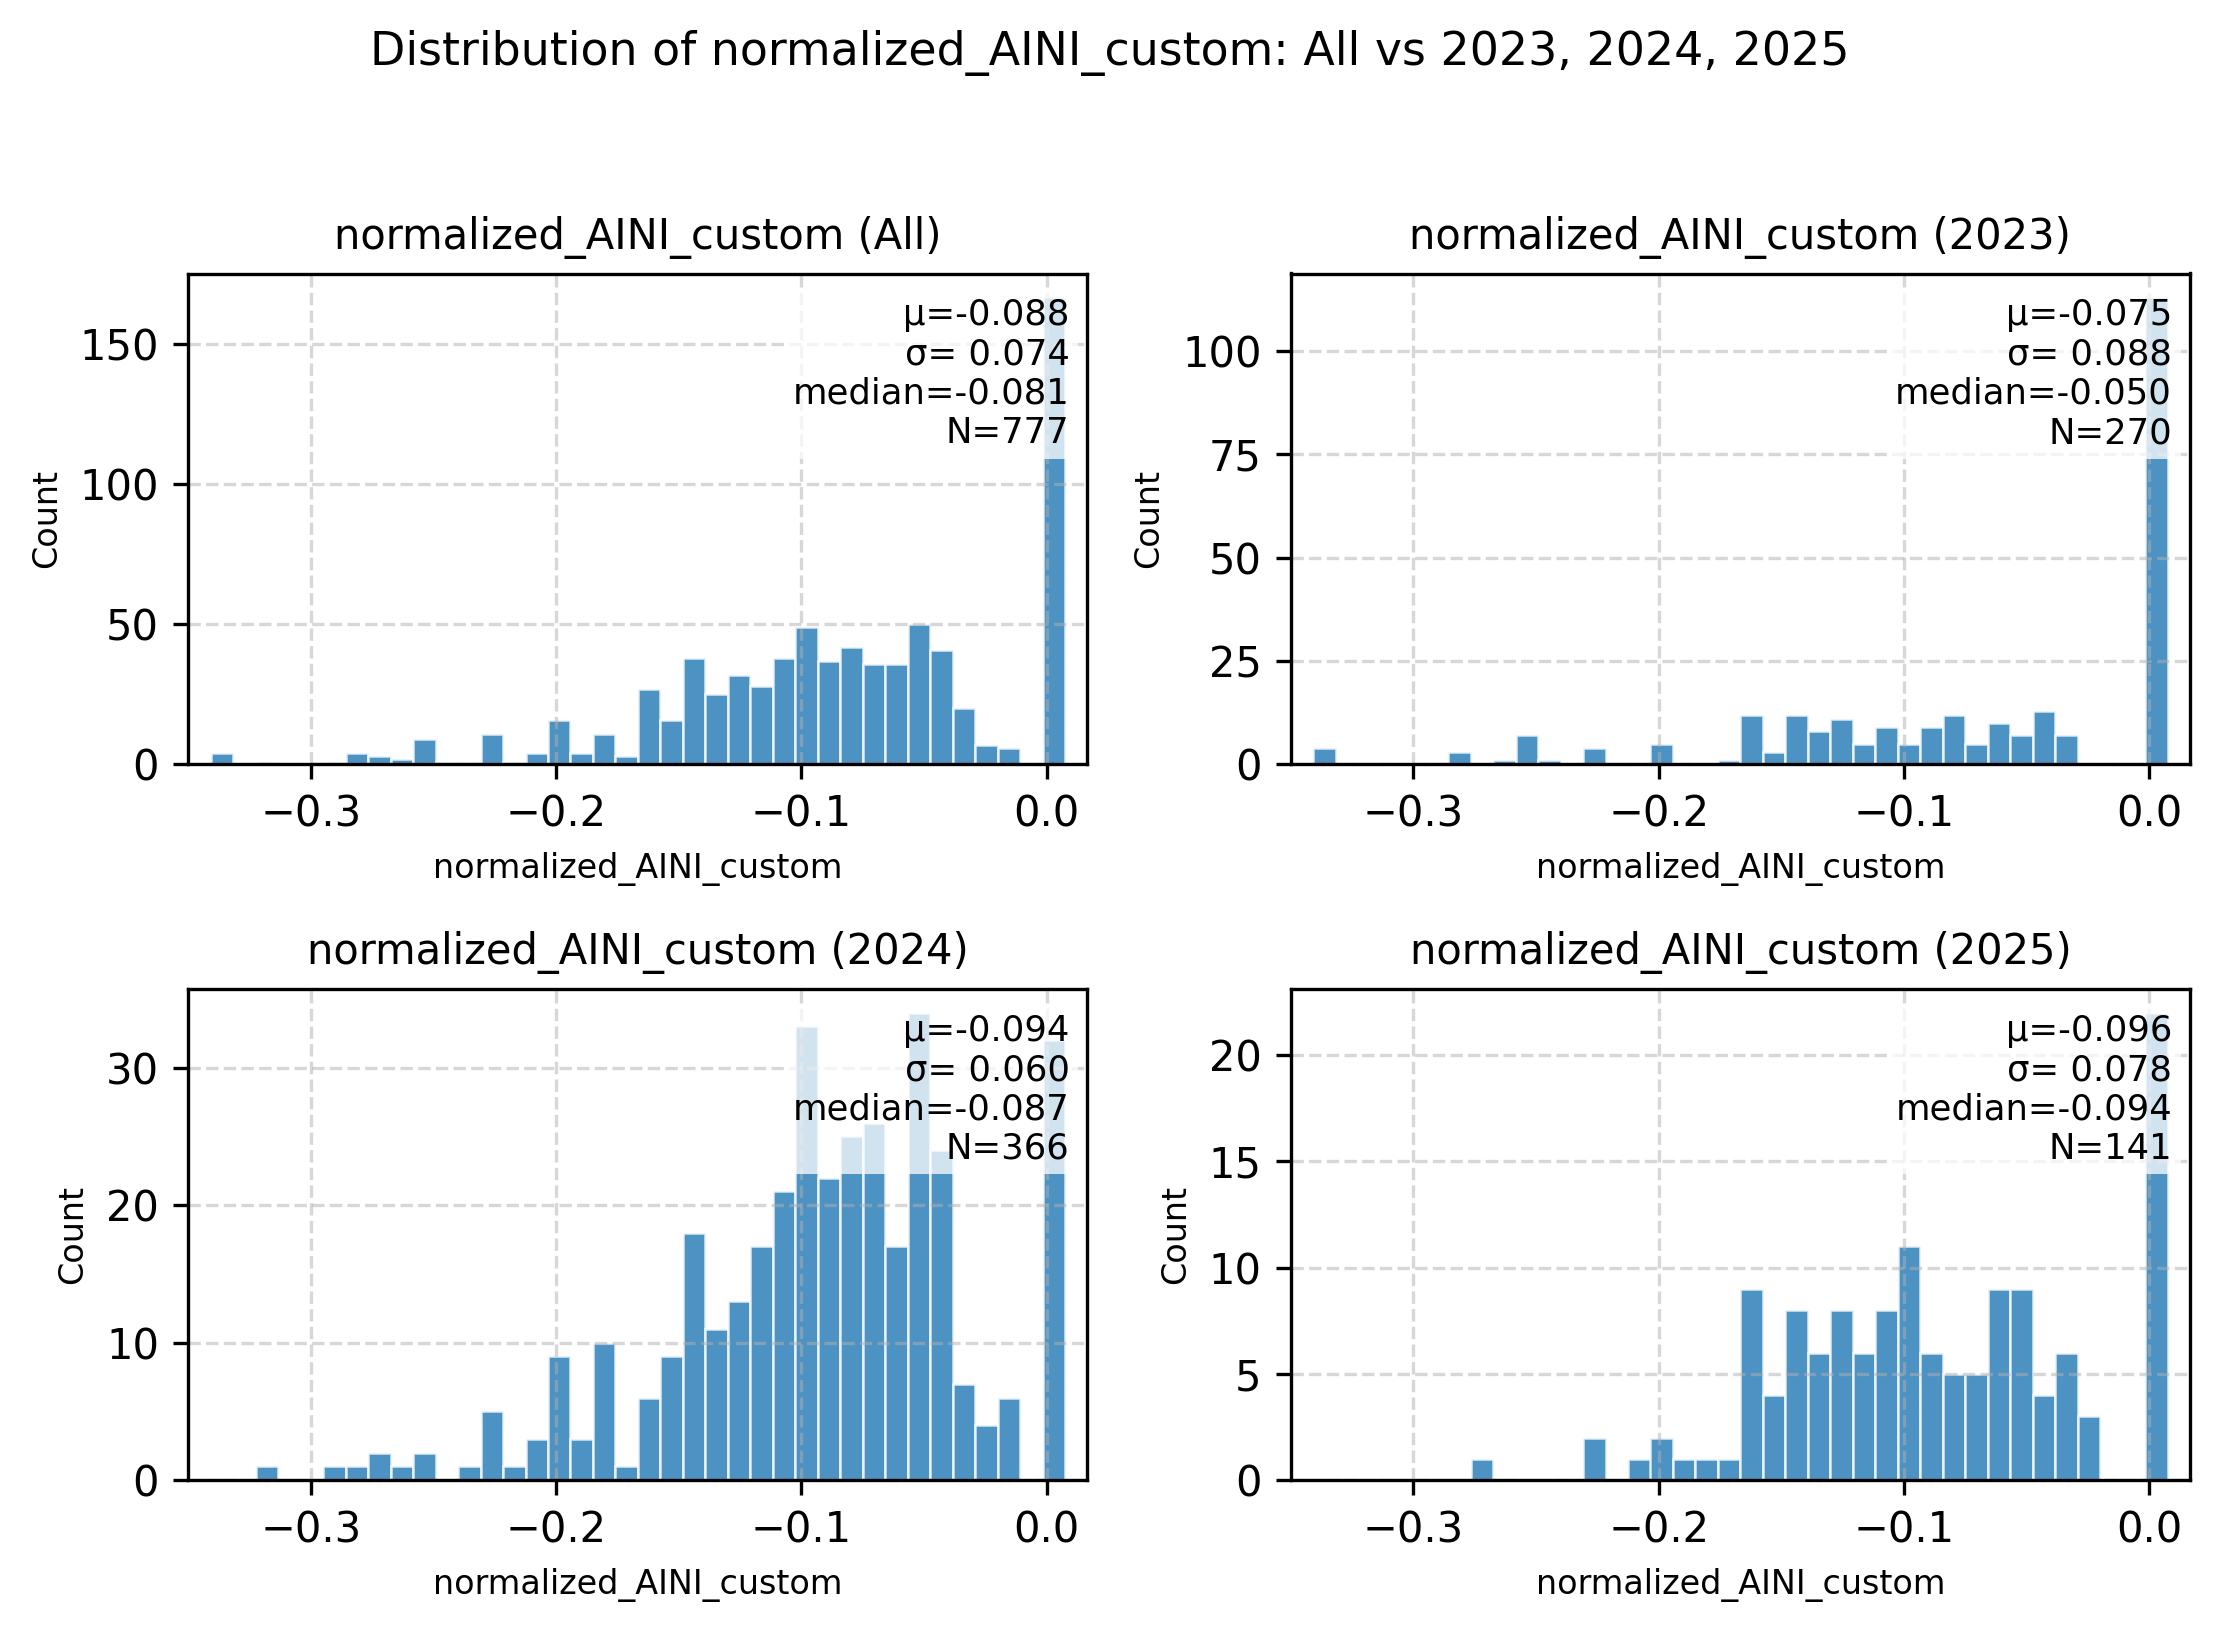

In [11]:
# plot distribution, ignoring raw counts due to unequal count of articles / day
outpath_hist = fig_path / "aini_hist_custom_panels.png"

plot_aini_hist_grid_by_years(
            df = merged,
            measure="normalized_AINI_custom",
            outpath= outpath_hist
        )


In [12]:
# write to csv
extrema.to_csv(table_path / "aini_extrema.csv")

In [13]:
# Convert to LaTeX with booktabs, tabular (single-page), wrapped in adjustbox
latex_table = extrema.to_latex(
    index=False,
    escape=True,
    column_format="l" + "c" * (len(extrema.columns) - 1),
    bold_rows=False
)

# Add booktabs spacing
latex_table = latex_table.replace("\\toprule", "\\toprule\n\\addlinespace")
latex_table = latex_table.replace("\\midrule", "\\midrule\n\\addlinespace")
latex_table = latex_table.replace("\\bottomrule", "\\addlinespace\n\\bottomrule")

# Wrap in table + adjustbox
latex_wrapped = (
    "\\begin{table}[!htbp]\n"
    "\\centering\n"
    "\\begin{adjustbox}{width=\\textwidth}\n"
    + latex_table +
    "\\end{adjustbox}\n"
    "\\caption{AINI extrema}\n"
    "\\label{tab:aini_extrema}\n"
    "\\end{table}\n"
)

# Save to file
output_path = table_path / "aini_extrema.tex"
with open(output_path, "w") as f:
    f.write(latex_wrapped)

Calculate weekly extrema (by calendar week)

In [14]:
# derive calendar week (ISO year + week number)
tidy["week"] = tidy["date"].dt.to_period("W").apply(lambda r: r.start_time)

# Count how often each min/max week occurs
counts_by_week = (
    tidy.groupby(["type", "week"])
        .size()
        .reset_index(name="count")
        .sort_values(["type", "count"], ascending=[True, False])
)

# subset n > 0
extrema_weekly = counts_by_week[counts_by_week["count"] > 0]

# collect variables for each week
week_dict = (
    tidy.groupby(["week"])["variable"]
    .apply(list)
    .to_dict()
)

# attach variables to each week
extrema_weekly["measure"] = extrema_weekly["week"].map(week_dict)

# bring into convenient format
extrema_weekly_clean = extrema_weekly.copy()

# week start (Monday)
week_start = extrema_weekly_clean["week"]
# week end (Sunday) = start + 6 days
week_end = week_start + pd.Timedelta(days=6)

# format as "dd.mm.yyyy - dd.mm.yyyy"
extrema_weekly_clean["week"] = (
    week_start.dt.strftime("%d.%m.%Y") + " - " + week_end.dt.strftime("%d.%m.%Y")
)

extrema_weekly_clean["type"] = extrema_weekly_clean["type"].replace({"min": "minimum", "max": "maximum"})
extrema_weekly_clean.rename(columns={"count": "n measures"}, inplace=True)

# save
extrema_weekly_clean.to_csv(table_path / "aini_weekly_extrema.csv", index=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_21612\2630997574.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tidy.groupby(["type", "week"])
C:\Users\PC\AppData\Local\Temp\ipykernel_21612\2630997574.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extrema_weekly["measure"] = extrema_weekly["week"].map(week_dict)
C:\Users\PC\AppData\Local\Temp\ipykernel_21612\2630997574.py:38: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the

In [15]:
# Convert to LaTeX with booktabs, tabular (single-page), wrapped in adjustbox
latex_table = extrema_weekly_clean.to_latex(
    index=False,
    escape=True,
    column_format="l" + "c" * (len(extrema_weekly_clean.columns) - 1),
    bold_rows=False
)

# Add booktabs spacing
latex_table = latex_table.replace("\\toprule", "\\toprule\n\\addlinespace")
latex_table = latex_table.replace("\\midrule", "\\midrule\n\\addlinespace")
latex_table = latex_table.replace("\\bottomrule", "\\addlinespace\n\\bottomrule")

# Wrap in table + adjustbox
latex_wrapped = (
    "\\begin{table}[!htbp]\n"
    "\\centering\n"
    "\\begin{adjustbox}{width=\\textwidth}\n"
    + latex_table +
    "\\end{adjustbox}\n"
    "\\caption{AINI extrema}\n"
    "\\label{tab:aini_extrema}\n"
    "\\end{table}\n"
)

# Save to file
output_path = table_path / "aini_extrema_weekly.tex"
with open(output_path, "w") as f:
    f.write(latex_wrapped)

In [16]:
extrema_weekly_clean.sort_values("n measures",ascending=False)

type                     week  n measures  \
6   minimum  27.01.2025 - 02.02.2025           4   
7   minimum  03.02.2025 - 09.02.2025           3   
21  maximum  02.06.2025 - 08.06.2025           3   
23  maximum  16.06.2025 - 22.06.2025           3   
1   minimum  07.08.2023 - 13.08.2023           2   
3   minimum  29.07.2024 - 04.08.2024           2   
22  maximum  09.06.2025 - 15.06.2025           2   
5   minimum  20.01.2025 - 26.01.2025           1   
12  maximum  03.04.2023 - 09.04.2023           1   
14  maximum  04.09.2023 - 10.09.2023           1   
16  maximum  07.10.2024 - 13.10.2024           1   
20  maximum  17.03.2025 - 23.03.2025           1   

                                              measure  
6   [normalized_AINI_w1, EMA_02_w1, EMA_08_w1, EMA...  
7   [normalized_AINI_custom, EMA_02_custom, EMA_08...  
21         [normalized_AINI_w0, EMA_02_w0, EMA_08_w0]  
23         [normalized_AINI_w2, EMA_02_w2, EMA_08_w2]  
1                     [normalized_AINI_w0, EMA_08_w0]  
3                     [normalized_AINI_w2, EMA_08_w2]  
22                    [normalized_AINI_w1, EMA_08_w1]  
5                                         [EMA_02_w0]  
12                                    [EMA_02_custom]  
14                                    [EMA_08_custom]  
16                           [normalized_AINI_custom]  
20                                        [EMA_02_w1]

load data with AINI predictions & compare corpora with maxima and minima

In [17]:
# load & merge w1 data custom finbert data
c_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_on_binary.csv")
c_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_on_binary.csv")
c_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_on_binary.csv")
c_df = pd.concat([c_df23,c_df24,c_df25]) 

# load & merge w0 data
w0_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_windsize_0.csv")
w0_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_0.csv")
w0_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_windsize_0.csv")
w0_df = pd.concat([w0_df23,w0_df24,w0_df25]) 

# load & merge w1 data
w1_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_windsize_1.csv")
w1_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_1.csv")
w1_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_windsize_1.csv")
w1_df = pd.concat([w1_df23,w1_df24,w1_df25]) 

# merge on normalized_aini_wo to identify relevant articles
w2_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_windsize_2.csv")
w2_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_2.csv")
w2_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_windsize_2.csv")
w2_df = pd.concat([w2_df23,w2_df24,w2_df25]) 

# create df list 
aini_dfs = [c_df,w0_df,w1_df,w2_df]
print(w0_df[w0_df["article_id"] == 20253960][["corpus","title"]])

                                                 corpus  \
3897  OPINION\nCOMMENTARY\nFollow\nAgency Overreach ...   

                                           title  
3897  Agency Overreach Leaves Patients Untreated  


In [18]:
# verify integrity 
for df in aini_dfs:
    print(
        f"\nFirst entry (date): {df['date'].min()} "
        f"\nLast entry (date): {df['date'].max()} "
        f"\n# entries: {len(df)} "
        f"\n# non-unique article_id: {df['article_id'].duplicated().sum()} "
        f"\n# unique article_id: {df['article_id'].nunique()} " 
        f"\nMin article_id: {df['article_id'].min()} "
        f"\nMax article_id: {df['article_id'].max()} "
        f"\nColumns: {list(df.columns)}\n"
    )



First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 21886 
# non-unique article_id: 0 
# unique article_id: 21886 
Min article_id: 20251 
Max article_id: 202437460 
Columns: ['article_id', 'image_src', 'scanned_time', 'title', 'sub_title', 'corpus', 'index_id', 'id', 'date', 'link', 'section', 'cleaned_corpus', 'ai_window', 'predicted_label', 'predicted_class', 'ai_relevant', 'sentiment_label', 'sentiment_score', 'hype_score']


First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
# unique article_id: 22904 
Min article_id: 20251 
Max article_id: 202437460 
Columns: ['article_id', 'image_src', 'scanned_time', 'title', 'sub_title', 'corpus', 'index_id', 'id', 'date', 'link', 'section', 'cleaned_corpus', 'text', 'ai_window', 'ai_relevant', 'sentiment_label', 'sentiment_score', 'hype_score']


First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
# unique a

In [19]:
# investigate duplicates in article ids
dups = w0_df[w0_df[["article_id", "title"]].duplicated(keep=False)].sort_values("article_id")
dups

Empty DataFrame
Columns: [article_id, image_src, scanned_time, title, sub_title, corpus, index_id, id, date, link, section, cleaned_corpus, text, ai_window, ai_relevant, sentiment_label, sentiment_score, hype_score]
Index: []

In [20]:
# subset for relevant columns
rel_col = ["date","article_id","sentiment_label","hype_score","ai_window"]
clean_df = []

for df in aini_dfs:
    df = df[rel_col].copy()
    clean_df.append(df)
    
# unpack supsetted dataframes containing Finbert AINI estimates    
c_df_sub,w0_df_sub,w1_df_sub,w2_df_sub = clean_df
w2_df_sub

date  article_id sentiment_label  hype_score  \
0     2023-01-10      202336         neutral           0   
1     2023-01-10      202339         neutral           0   
2     2023-01-12      202387         neutral           0   
3     2023-01-12     2023102         neutral           0   
4     2023-01-13     2023111         neutral           0   
...          ...         ...             ...         ...   
4055  2025-06-16    20254120         neutral           0   
4056  2025-06-16    20254121         neutral           0   
4057  2025-06-16    20254122         neutral           0   
4058  2025-06-16    20254123         neutral           0   
4059  2025-06-16    20254124        positive           1   

                                              ai_window  
0                                                   NaN  
1                                                   NaN  
2                                                   NaN  
3                                                   NaN  
4                                                   NaN  
...                                                 ...  
4055                                                NaN  
4056                                                NaN  
4057                                                NaN  
4058                                                NaN  
4059  the investment of 20 billion. australian dolla...  

[22904 rows x 5 columns]

In [21]:
# verify integrity 
for df in clean_df:
    print(
        f"First entry (date): {df['date'].min()} "
        f"\nLast entry (date): {df['date'].max()} "
        f"\n# entries: {len(df)} "
        f"\n# non-unique article_id: {df['article_id'].duplicated().sum()} "
        f"\nColumns: {list(df.columns)}\n"
    )


First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 21886 
# non-unique article_id: 0 
Columns: ['date', 'article_id', 'sentiment_label', 'hype_score', 'ai_window']

First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
Columns: ['date', 'article_id', 'sentiment_label', 'hype_score', 'ai_window']

First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
Columns: ['date', 'article_id', 'sentiment_label', 'hype_score', 'ai_window']

First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
Columns: ['date', 'article_id', 'sentiment_label', 'hype_score', 'ai_window']



Combine AINI predictions to investigate minima & maxima

In [22]:
# harmonize ids
w0 = w0_df_sub.copy()
w1 = w1_df_sub.copy()
w2 = w2_df_sub.copy()
c  = c_df_sub.copy()

# bring to datetime, normalize to 00:00:00
for df in (w0, w1, w2, c):
    df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()

# left join
complete_left = w0.copy()
complete_left = complete_left.merge(
    w1, on="article_id", how="left", suffixes=("", "_w1"), validate="one_to_one"
)
complete_left = complete_left.merge(
    w2, on="article_id", how="left", suffixes=("", "_w2"), validate="one_to_one"
)
complete_left = complete_left.merge(
    c,  on="article_id", how="left", suffixes=("", "_c"),  validate="one_to_one"
)

# control: outer join
complete_outer = w0.merge(
    w1, on="article_id", how="outer", suffixes=("", "_w1"), validate="one_to_one"
)
complete_outer = complete_outer.merge(
    w2, on="article_id", how="outer", suffixes=("", "_w2"), validate="one_to_one"
)
complete_outer = complete_outer.merge(
    c,  on="article_id", how="outer", suffixes=("", "_c"),  validate="one_to_one"
)


# compare joins
print("[LEFT] n observations:", len(complete_left))
print("[OUTER] n observations:", len(complete_outer))
complete_left

[LEFT] n observations: 22904
[OUTER] n observations: 22904


date  article_id sentiment_label  hype_score  \
0     2023-01-10      202336         neutral           0   
1     2023-01-10      202339         neutral           0   
2     2023-01-12      202387         neutral           0   
3     2023-01-12     2023102         neutral           0   
4     2023-01-13     2023111         neutral           0   
...          ...         ...             ...         ...   
22899 2025-06-16    20254120         neutral           0   
22900 2025-06-16    20254121         neutral           0   
22901 2025-06-16    20254122         neutral           0   
22902 2025-06-16    20254123         neutral           0   
22903 2025-06-16    20254124        positive           1   

                                               ai_window    date_w1  \
0                                                    NaN 2023-01-10   
1                                                    NaN 2023-01-10   
2                                                    NaN 2023-01-12   
3                                                    NaN 2023-01-12   
4                                                    NaN 2023-01-13   
...                                                  ...        ...   
22899                                                NaN 2025-06-16   
22900                                                NaN 2025-06-16   
22901                                                NaN 2025-06-16   
22902                                                NaN 2025-06-16   
22903  ai capabilities to support strong demand from ... 2025-06-16   

      sentiment_label_w1  hype_score_w1  \
0                neutral              0   
1                neutral              0   
2                neutral              0   
3                neutral              0   
4                neutral              0   
...                  ...            ...   
22899            neutral              0   
22900            neutral              0   
22901            neutral              0   
22902            neutral              0   
22903           positive              1   

                                            ai_window_w1    date_w2  \
0                                                    NaN 2023-01-10   
1                                                    NaN 2023-01-10   
2                                                    NaN 2023-01-12   
3                                                    NaN 2023-01-12   
4                                                    NaN 2023-01-13   
...                                                  ...        ...   
22899                                                NaN 2025-06-16   
22900                                                NaN 2025-06-16   
22901                                                NaN 2025-06-16   
22902                                                NaN 2025-06-16   
22903  australian dollars, the equivalent of 12. 97 b... 2025-06-16   

      sentiment_label_w2  hype_score_w2  \
0                neutral              0   
1                neutral              0   
2                neutral              0   
3                neutral              0   
4                neutral              0   
...                  ...            ...   
22899            neutral              0   
22900            neutral              0   
22901            neutral              0   
22902            neutral              0   
22903           positive              1   

                                            ai_window_w2     date_c  \
0                                                    NaN 2023-01-10   
1                                                    NaN 2023-01-10   
2                                                    NaN 2023-01-12   
3                                                    NaN 2023-01-12   
4                                                    NaN 2023-01-13   
...                                                  ...        ...   
22899                                                N

In [23]:
# columns to bring over from w1_df
keep = ["article_id", "title", "sub_title","section", "cleaned_corpus", "date","ai_window"]

# subset + clean IDs on the right side
for_texts = w1_df.loc[:, keep].copy()
for_texts["article_id"] = (
    for_texts["article_id"]
    .astype(str)
    .str.replace(r"[\u200b\u200c\u200d\ufeff]", "", regex=True)  # zero-width + BOM
    .str.strip()
)

# ensure right side has unique keys 
for_texts = for_texts.drop_duplicates(subset="article_id", keep="first")

# clean IDs on the left
complete_left = complete_left.copy()
complete_left["article_id"] = (
    complete_left["article_id"]
    .astype(str)
    .str.replace(r"[\u200b\u200c\u200d\ufeff]", "", regex=True)
    .str.strip()
)

# go for left join (validated by inner)
complete_df = complete_left.copy()

# rename for consistency
complete_df = complete_df.rename(columns={"hype_score": "hype_score_w0"})
complete_df

date article_id sentiment_label  hype_score_w0  \
0     2023-01-10     202336         neutral              0   
1     2023-01-10     202339         neutral              0   
2     2023-01-12     202387         neutral              0   
3     2023-01-12    2023102         neutral              0   
4     2023-01-13    2023111         neutral              0   
...          ...        ...             ...            ...   
22899 2025-06-16   20254120         neutral              0   
22900 2025-06-16   20254121         neutral              0   
22901 2025-06-16   20254122         neutral              0   
22902 2025-06-16   20254123         neutral              0   
22903 2025-06-16   20254124        positive              1   

                                               ai_window    date_w1  \
0                                                    NaN 2023-01-10   
1                                                    NaN 2023-01-10   
2                                                    NaN 2023-01-12   
3                                                    NaN 2023-01-12   
4                                                    NaN 2023-01-13   
...                                                  ...        ...   
22899                                                NaN 2025-06-16   
22900                                                NaN 2025-06-16   
22901                                                NaN 2025-06-16   
22902                                                NaN 2025-06-16   
22903  ai capabilities to support strong demand from ... 2025-06-16   

      sentiment_label_w1  hype_score_w1  \
0                neutral              0   
1                neutral              0   
2                neutral              0   
3                neutral              0   
4                neutral              0   
...                  ...            ...   
22899            neutral              0   
22900            neutral              0   
22901            neutral              0   
22902            neutral              0   
22903           positive              1   

                                            ai_window_w1    date_w2  \
0                                                    NaN 2023-01-10   
1                                                    NaN 2023-01-10   
2                                                    NaN 2023-01-12   
3                                                    NaN 2023-01-12   
4                                                    NaN 2023-01-13   
...                                                  ...        ...   
22899                                                NaN 2025-06-16   
22900                                                NaN 2025-06-16   
22901                                                NaN 2025-06-16   
22902                                                NaN 2025-06-16   
22903  australian dollars, the equivalent of 12. 97 b... 2025-06-16   

      sentiment_label_w2  hype_score_w2  \
0                neutral              0   
1                neutral              0   
2                neutral              0   
3                neutral              0   
4                neutral              0   
...                  ...            ...   
22899            neutral              0   
22900            neutral              0   
22901            neutral              0   
22902            neutral              0   
22903           positive              1   

                                            ai_window_w2     date_c  \
0                                                    NaN 2023-01-10   
1                                                    NaN 2023-01-10   
2                                                    NaN 2023-01-12   
3                                                    NaN 2023-01-12   
4                                                    NaN 2023-01-13   
...                                                  ...        ...   
22899                         

C:\Users\PC\AppData\Local\Temp\ipykernel_21612\2337388238.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df["hype_score_mean"] = complete_df[hype_cols].mean(axis=1)
C:\Users\PC\AppData\Local\Temp\ipykernel_21612\2337388238.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")


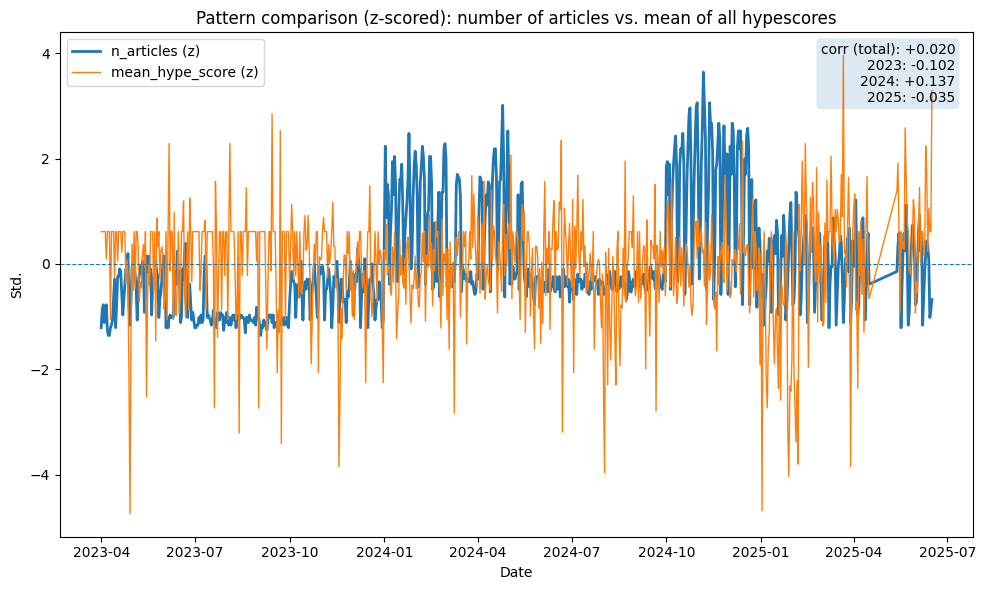

In [24]:
# define noisy dates 
exclude_dates=["2023-07-15","2023-06-30"]

# subset to exclude noise
complete_df = complete_df[~complete_df["date"].isin(pd.to_datetime(exclude_dates))]

# define relevant columns
hype_cols = ["hype_score_w0", "hype_score_w1", "hype_score_w2", "hype_score_c"]

# compute row-wise mean across all hype scores (per article)
complete_df["hype_score_mean"] = complete_df[hype_cols].mean(axis=1)

# aggregate to date level: count articles and mean of the row-wise mean
complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")
complete_agg = (
    complete_df.groupby("date", as_index=False)
    .agg(
        n_articles=("article_id", "count"),
        mean_hype_score=("hype_score_mean", "mean")
    )
)

# subset to exclude data prior 01.04.2023
cutoff = dt.datetime(2023, 4, 1)
complete_agg = complete_agg[complete_agg["date"] >= cutoff]

# prepare dataframe for plotting
dfp = complete_agg.set_index("date").copy()

# z-score helper that avoids div-by-zero
def zscore(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std()
    if pd.isna(sd) or sd == 0:
        return s * 0  # all zeros if no variation
    return (s - mu) / sd

# z-score series
dfp["n_articles_z"] = zscore(dfp["n_articles"])
dfp["mean_hype_score_z"] = zscore(dfp["mean_hype_score"])

# total corr
r_total = float(dfp["n_articles_z"].corr(dfp["mean_hype_score_z"]))

# yearly corrs
yearly_corrs = {}
for y, g in dfp.groupby(dfp.index.year):
    if len(g) >= 2:
        yearly_corrs[int(y)] = float(g["n_articles_z"].corr(g["mean_hype_score_z"]))
    else:
        yearly_corrs[int(y)] = np.nan

# build annotation text
lines = [f"corr (total): {r_total:+.3f}"]
for y in sorted(yearly_corrs):
    r = yearly_corrs[y]
    lines.append(f"{y}: {r:+.3f}" if np.isfinite(r) else f"{y}: n/a")
anno_text = "\n".join(lines)

# plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(dfp.index, dfp["n_articles_z"], linewidth=2, label="n_articles (z)")
ax.plot(dfp.index, dfp["mean_hype_score_z"], linewidth=1, label="mean_hype_score (z)")

ax.axhline(0, linestyle="--", linewidth=0.8)
ax.set_title("Pattern comparison (z-scored): number of articles vs. mean of all hypescores")
ax.set_xlabel("Date")
ax.set_ylabel("Std.")
ax.legend(loc="upper left", ncol=1)

# annotation box (upper right inside axes)
ax.text(
    0.98, 0.98, anno_text,
    transform=ax.transAxes,
    ha="right", va="top",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.15, edgecolor="none")
)

fig.tight_layout()
plt.show()

Investigate yearly correlation between raw hype scores & number of articles

Compute correlation between n articles & processed AINI values

In [25]:
MEASURE_COLS = [
    "normalized_AINI_w0", "EMA_02_w0", "EMA_08_w0",
    "normalized_AINI_w1",  "EMA_02_w1", "EMA_08_w1",
    "normalized_AINI_w2", "EMA_02_w2", "EMA_08_w2",
    "normalized_AINI_custom", "EMA_02_custom", "EMA_08_custom",
]

merged_df = merged.copy()
merged_df["date"] = pd.to_datetime(merged_df["date"], errors="coerce")
merged_df = merged_df.dropna(subset=["date"])
present_measures = [c for c in MEASURE_COLS if c in merged_df.columns]

n_base = complete_agg[["date", "n_articles"]].copy()

# join measures with n_articles on date 
m = (
    merged_df[["date"] + present_measures]
    .merge(n_base, on="date", how="inner")
    .sort_values("date")
)

# verify integrity
print(f"Number of measures {m.shape[0]}",
      f"\n First datapoint: {min(m.date)}",
      f"\n Last datapoint: {max(m.date)}",
      f"\n Duplicates: {m['date'].duplicated().sum()}")

m_sub = m["date","normalized_AINI_w0"]

Number of measures 777 
 First datapoint: 2023-04-03 00:00:00 
 Last datapoint: 2025-06-16 00:00:00 
 Duplicates: 0


KeyError: ('date', 'normalized_AINI_w0')

Calculate means  & rations of means against each other

In [ ]:
# --- columns for aggregation ---
w0_col = ["normalized_AINI_w0"]
w1_col = ["normalized_AINI_w1"]
w2_col = ["normalized_AINI_w2"]
c_col  = ["normalized_AINI_custom"]

# per-row means 
m["w0_mean"] = m[w0_col].mean(axis=1)
m["w1_mean"] = m[w1_col].mean(axis=1)
m["w2_mean"] = m[w2_col].mean(axis=1)
m["c_mean"]  = m[c_col].mean(axis=1)

group_cols = ["w0_mean", "w1_mean", "w2_mean", "c_mean"]

# helpers
def _fmt(mean_val, std_val, nd=4):
    if pd.isna(mean_val):
        return "NaN"
    if pd.isna(std_val):
        return f"{mean_val:.{nd}f} (NaN)"
    return f"{mean_val:.{nd}f} ({std_val:.{nd}f})"

def overlapping_window_stats(df: pd.DataFrame, cols, window_size: int = 2) -> pd.DataFrame:
    years = sorted(int(y) for y in df["date"].dt.year.dropna().unique())
    rows_mean, rows_std = {}, {}
    for i in range(len(years) - window_size + 1):
        y0, y1 = years[i], years[i + window_size - 1]
        mask = df["date"].dt.year.between(y0, y1)
        label = f"{y0}–{y1}"
        rows_mean[label] = df.loc[mask, cols].mean()
        rows_std[label]  = df.loc[mask, cols].std(ddof=1)
    if not rows_mean:
        return pd.DataFrame(columns=pd.MultiIndex.from_product([cols, ["mean", "std"]]))
    mean_df = pd.DataFrame.from_dict(rows_mean, orient="index")[cols]
    std_df  = pd.DataFrame.from_dict(rows_std,  orient="index")[cols]
    out = pd.concat(
        { "mean": mean_df, "std": std_df },
        axis=1
    ) 

    out = out.swaplevel(0,1, axis=1).sort_index(axis=1)
    return out

# yearly stats (exclude 2025) 
yearly_stats = (
    m.groupby(m["date"].dt.year, dropna=True)[group_cols]
     .agg(['mean', 'std'])
     .drop(index=2025, errors="ignore")
)  # MultiIndex columns: (col, stat)

# overlapping 2-year windows 
overlap_stats = overlapping_window_stats(m, group_cols, window_size=2)

# total over all years
total_mean = m[group_cols].mean().to_frame().T
total_std  = m[group_cols].std(ddof=1).to_frame().T
total_stats = pd.concat({"mean": total_mean, "std": total_std}, axis=1)
total_stats = total_stats.swaplevel(0,1, axis=1).sort_index(axis=1)
total_stats.index = ["2023-2025"]

# combine
means_only_years = yearly_stats.xs("mean", axis=1, level=1)
means_only_over  = overlap_stats.xs("mean", axis=1, level=1) if not overlap_stats.empty else pd.DataFrame()
means_only_total = total_stats.xs("mean", axis=1, level=1)

std_only_years = yearly_stats.xs("std", axis=1, level=1)
std_only_over  = overlap_stats.xs("std", axis=1, level=1) if not overlap_stats.empty else pd.DataFrame()
std_only_total = total_stats.xs("std", axis=1, level=1)

means_only = pd.concat([means_only_years, means_only_over, means_only_total], axis=0)
std_only   = pd.concat([std_only_years,   std_only_over,   std_only_total],   axis=0)

# ensure order
years_sorted   = [i for i in means_only_years.index]
overlap_sorted = [i for i in means_only_over.index]
order = years_sorted + overlap_sorted + ["2023-2025"]
means_only = means_only.reindex(order)
std_only   = std_only.reindex(order)

# formatted table: "mean (std)" 
formatted = pd.DataFrame(index=means_only.index, columns=group_cols)
for c in group_cols:
    formatted[c] = [
        _fmt(means_only.loc[idx, c], std_only.loc[idx, c], nd=4)
        for idx in means_only.index
    ]

# pairwise ratios from numeric means 
fractions = {}
for a in group_cols:
    for b in group_cols:
        if a != b:
            fractions[f"{a}/{b}"] = means_only[a].div(means_only[b].replace(0, np.nan))
frac_df = pd.DataFrame(fractions, index=means_only.index)

#  outputs 
print(formatted)           
print(frac_df.round(4))   


                    w0_mean           w1_mean           w2_mean  \
2023       -0.0021 (0.0479)  -0.0026 (0.0414)  -0.0060 (0.0425)   
2024        0.0005 (0.0321)  -0.0055 (0.0393)  -0.0055 (0.0408)   
2023–2024  -0.0006 (0.0396)  -0.0043 (0.0402)  -0.0057 (0.0415)   
2024–2025   0.0012 (0.0435)  -0.0040 (0.0503)  -0.0039 (0.0504)   
2023-2025   0.0001 (0.0451)  -0.0035 (0.0473)  -0.0047 (0.0478)   

                     c_mean  
2023       -0.0749 (0.0878)  
2024       -0.0937 (0.0598)  
2023–2024  -0.0857 (0.0735)  
2024–2025  -0.0943 (0.0652)  
2023-2025  -0.0876 (0.0744)  
           w0_mean/w1_mean  w0_mean/w2_mean  w0_mean/c_mean  w1_mean/w0_mean  \
2023                0.7922           0.3480          0.0277           1.2623   
2024               -0.0936          -0.0931         -0.0055         -10.6797   
2023–2024           0.1373           0.1027          0.0068           7.2858   
2024–2025          -0.3091          -0.3162         -0.0132          -3.2350   
2023-2025        

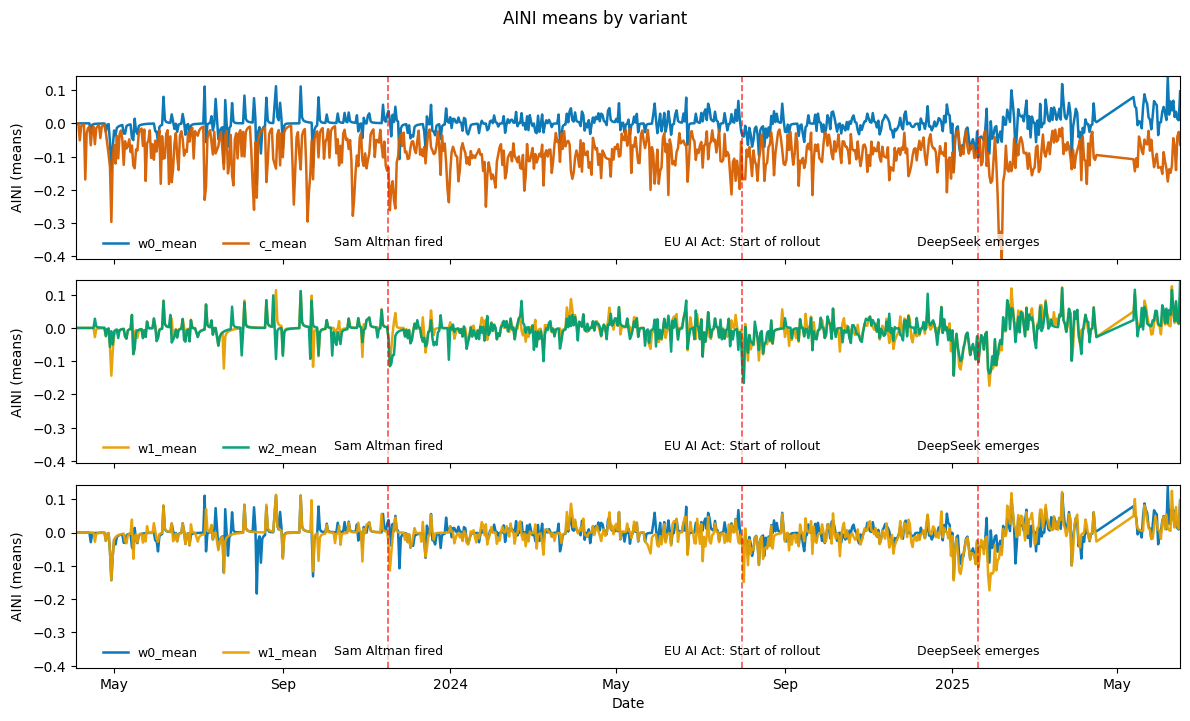

In [ ]:
plot_path = fig_path / "aini_means.png"
plot_aini_means_three_panels(m,
                            title = "AINI means by variant",
                            outpath = plot_path )

Investigate extrema manually

In [ ]:
# exclude 0 values [created due to symmetrie]
extrema = extrema[extrema["n measures"] > 0]

# again display extrema to define minima & maxima
extrema.sort_values(["type","n measures"],ascending=(False,False))

type        date  n measures  \
13  maximum  2025-06-07           3   
14  maximum  2025-06-16           3   
15  maximum  2025-06-10           2   
16  maximum  2023-04-09           1   
17  maximum  2023-09-07           1   
18  maximum  2024-10-10           1   
19  maximum  2025-03-22           1   
0   minimum  2025-02-06           3   
1   minimum  2023-08-13           2   
2   minimum  2024-08-02           2   
3   minimum  2025-01-28           2   
4   minimum  2025-01-31           2   
5   minimum  2025-01-20           1   

                                              measure  
13           normalized_AINI_w0, EMA_02_w0, EMA_08_w0  
14           normalized_AINI_w2, EMA_02_w2, EMA_08_w2  
15                      normalized_AINI_w1, EMA_08_w1  
16                                      EMA_02_custom  
17                                      EMA_08_custom  
18                             normalized_AINI_custom  
19                                          EMA_02_w1  
0   normalized_AINI_custom, EMA_02_custom, EMA_08_...  
1                       normalized_AINI_w0, EMA_08_w0  
2                       normalized_AINI_w2, EMA_08_w2  
3                       normalized_AINI_w1, EMA_08_w1  
4                                EMA_02_w1, EMA_02_w2  
5                                           EMA_02_w0

In [ ]:

# cutoffs for minima 
min_1_custom  = pd.Timestamp("2025-02-06")  # n = 3 normalized_AINI_custom, EMA_02_custom, EMA_08_custom
min_2_w0      = pd.Timestamp("2023-08-13")  # n = 2 normalized_AINI_w0, EMA_08_w0
min_2_w1      = pd.Timestamp("2025-01-28")  # n = 2 normalized_AINI_w1, EMA_08_w1
min_2_w2      = pd.Timestamp("2024-08-02")  # n = 2 normalized_AINI_w2, EMA_08_w2
min_2_w1_w2   = pd.Timestamp("2025-01-31")  # n = 2 EMA_02_w1, EMA_02_w2 => only mixed!
min_3_w0_02   = pd.Timestamp("2025-01-20")  # n = 1 EMA_02_w0

# cutoffs for maxima, n = 3  
max_1_w0 = pd.Timestamp("2025-06-07")  # n = 3 normalized_AINI_w0, EMA_02_w0, EMA_08_w0
max_1_w2 = pd.Timestamp("2025-06-16")  # n = 3 normalized_AINI_w2, EMA_02_w2, EMA_08_w2

# cutoffs for maxima, n = 2  
max_2_w1 = pd.Timestamp("2025-06-10")  # n = 2 normalized_AINI_w1, EMA_08_w1            

# cutoffs for maxima, n = 1 
max_3_c_norm = pd.Timestamp("2024-10-10")  # n = 1 normalized_AINI_custom
max_3_c_02   = pd.Timestamp("2023-04-09")  # n = 1 EMA_02_custom
max_3_c_08   = pd.Timestamp("2023-09-07")  # n = 1 EMA_08_custom
max_3_w1_02  = pd.Timestamp("2025-03-22")  # n = 1 EMA_02_w1

# define cutoffs in a dict: name -> timestamp (single definition)
cutoffs = {
    # maxima, n=3
    "art_max_1_w0": max_1_w0,
    "art_max_1_w2": max_1_w2,
    # maxima, n=2
    "art_max_2_w1": max_2_w1,
    # maxima, n=1
    "art_max_3_c_norm": max_3_c_norm,
    "art_max_3_c_02":   max_3_c_02,
    "art_max_3_c_08":   max_3_c_08,
    "art_max_3_w1_02":  max_3_w1_02,
    # minima, n=3
    "art_min_1_custom": min_1_custom,
    # minima, n=2
    "art_min_2_w0":    min_2_w0,
    "art_min_2_w1":    min_2_w1,
    "art_min_2_w2":    min_2_w2,
    "art_min_2_w1_w2": min_2_w1_w2,
    # minima, n=1
    "art_min_3_w0_02": min_3_w0_02,
}

# ensure datetime
complete_df = complete_df.copy()
complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")

# subset original dataframe by each cutoff date
subsets = {
    name: complete_df.loc[complete_df["date"] == ts].copy()
    for name, ts in cutoffs.items()
}

# helper to count NA-rows for sanity check
def count_nonzero_rows(df, cols=None):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    arr = df[cols].fillna(0).to_numpy() if cols else np.empty((len(df), 0))
    return int((arr != 0).any(axis=1).sum()) if arr.size else 0

# check n of observations for all cutoffs (per subset)
for name, df in subsets.items():
    hype_cols = [c for c in ["hype_score_w0","hype_score_w1","hype_score_w2","hype_score_custom","hype_score_c"] if c in df.columns]
    n_nonzero = count_nonzero_rows(df, cols=hype_cols or None)
    print(f"{name}: Total: {len(df)} non-0: {n_nonzero}")

subsets

art_max_1_w0: Total: 5 non-0: 1
art_max_1_w2: Total: 15 non-0: 3
art_max_2_w1: Total: 33 non-0: 9
art_max_3_c_norm: Total: 79 non-0: 6
art_max_3_c_02: Total: 1 non-0: 0
art_max_3_c_08: Total: 5 non-0: 0
art_max_3_w1_02: Total: 6 non-0: 1
art_min_1_custom: Total: 44 non-0: 24
art_min_2_w0: Total: 7 non-0: 2
art_min_2_w1: Total: 36 non-0: 11
art_min_2_w2: Total: 19 non-0: 5
art_min_2_w1_w2: Total: 33 non-0: 5
art_min_3_w0_02: Total: 23 non-0: 5


{'art_max_1_w0':             date article_id sentiment_label  hype_score_w0  \
 22687 2025-06-07   20253906         neutral              0   
 22688 2025-06-07   20253907        positive              1   
 22689 2025-06-07   20253908         neutral              0   
 22690 2025-06-07   20253909         neutral              0   
 22691 2025-06-07   20253910         neutral              0   
 
                                                ai_window    date_w1  \
 22687                                                NaN 2025-06-07   
 22688  ai and crypto czar, has been privately encoura... 2025-06-07   
 22689                                                NaN 2025-06-07   
 22690                                                NaN 2025-06-07   
 22691                                                NaN 2025-06-07   
 
       sentiment_label_w1  hype_score_w1  \
 22687            neutral              0   
 22688            neutral              0   
 22689            neutral             

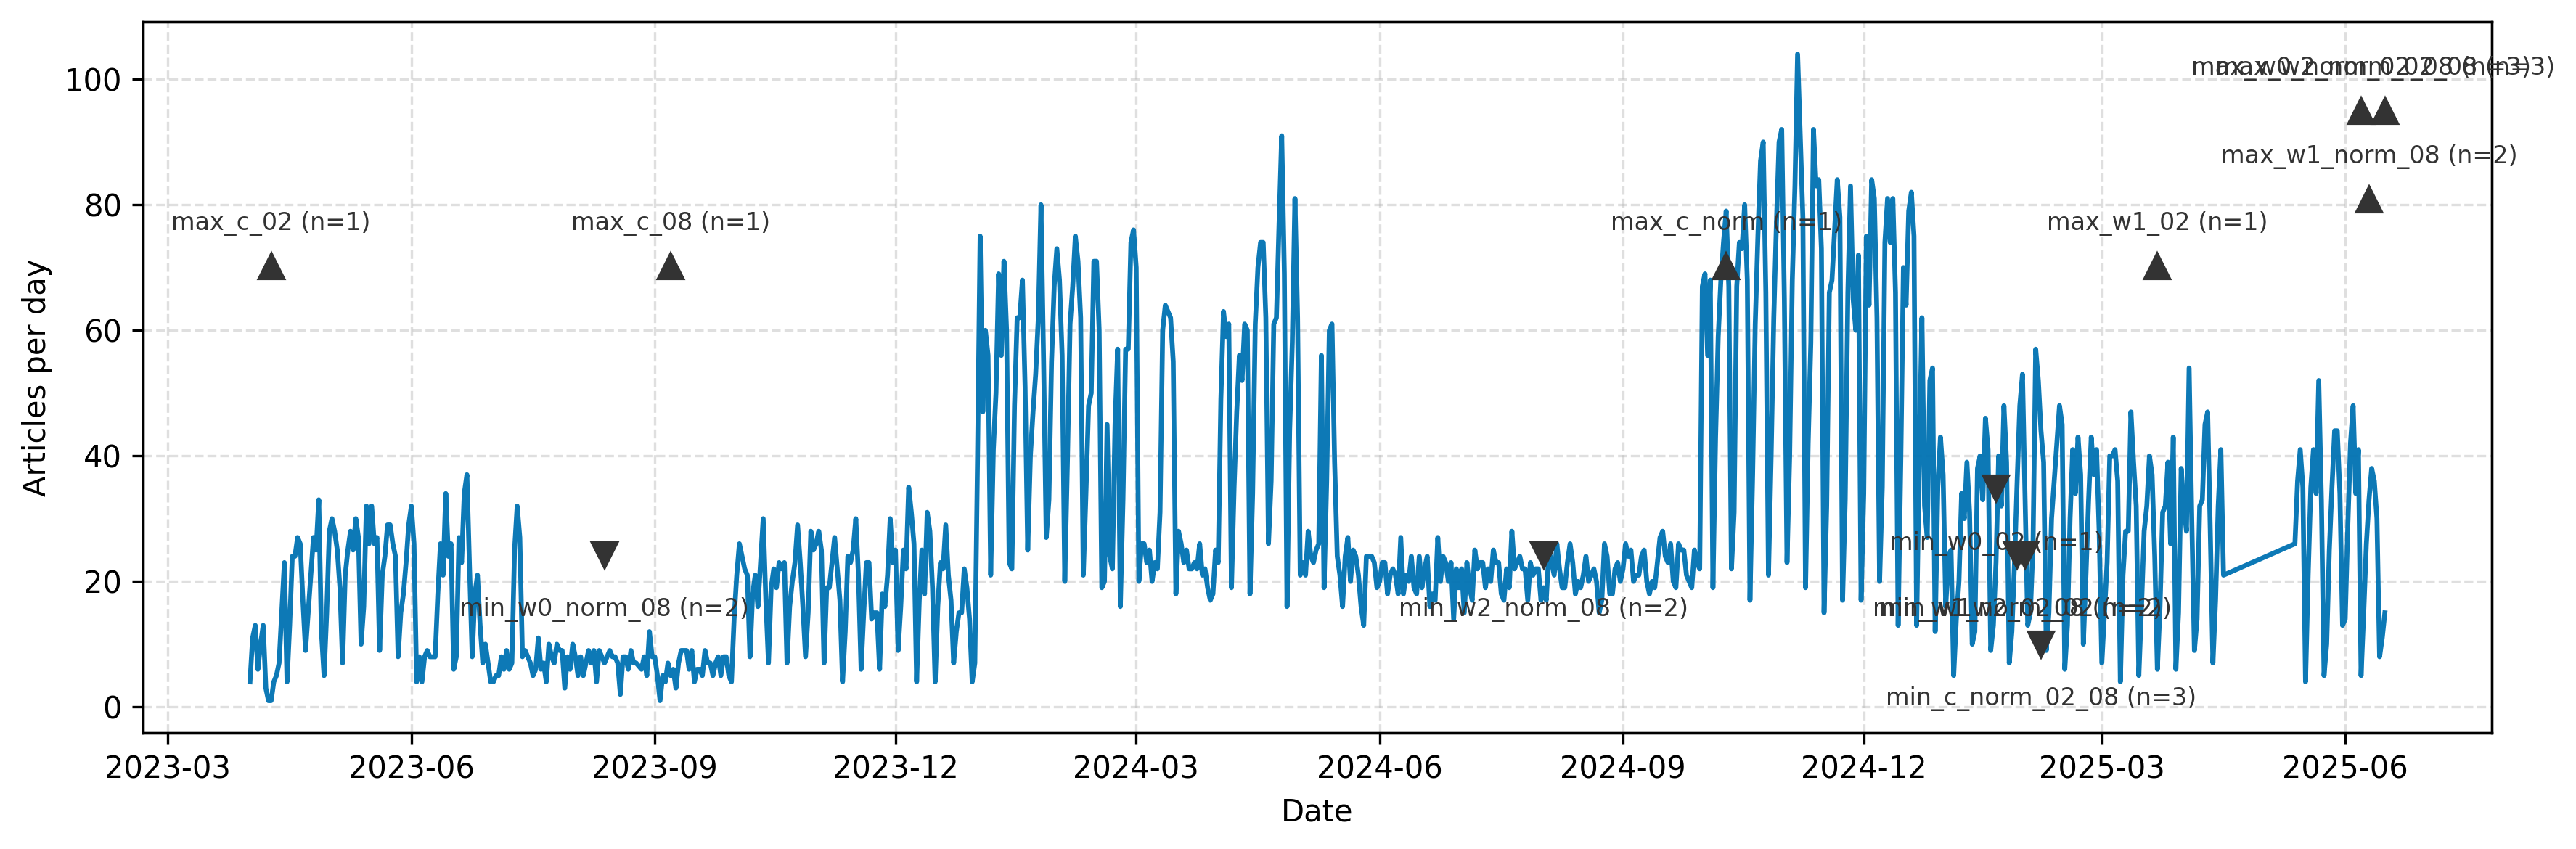

In [ ]:
# plot timeline
fig, ax = plot_n_articles_with_extrema_events(
    dfp=dfp, date_col=None, count_col="n_articles",
    outpath="reports/figures/n_articles_with_extrema.png", annotate=True
)

In [ ]:
# save extrema for reporting
extrema.sort_values(["type","n measures"],ascending=(False,False)).to_csv(var_path/ "extrema.csv")

Ensure article count does not bias AINI

Manually investiagte Minima & Maxima

In [ ]:
# drop noisy estimates
#merged_clean = merged[merged["date"] != min_1]

# ensure datetime type
complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")

# subsets per year
df_2023 = complete_df[complete_df["date"].dt.year == 2023]
df_2024 = complete_df[complete_df["date"].dt.year == 2024]
df_2025 = complete_df[complete_df["date"].dt.year == 2025]


Investigate AINI by year

Compare measures across each other

Manually investigate atricles on extrema-dates

Saved: C:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\reports\figures\extrema_timeline.png


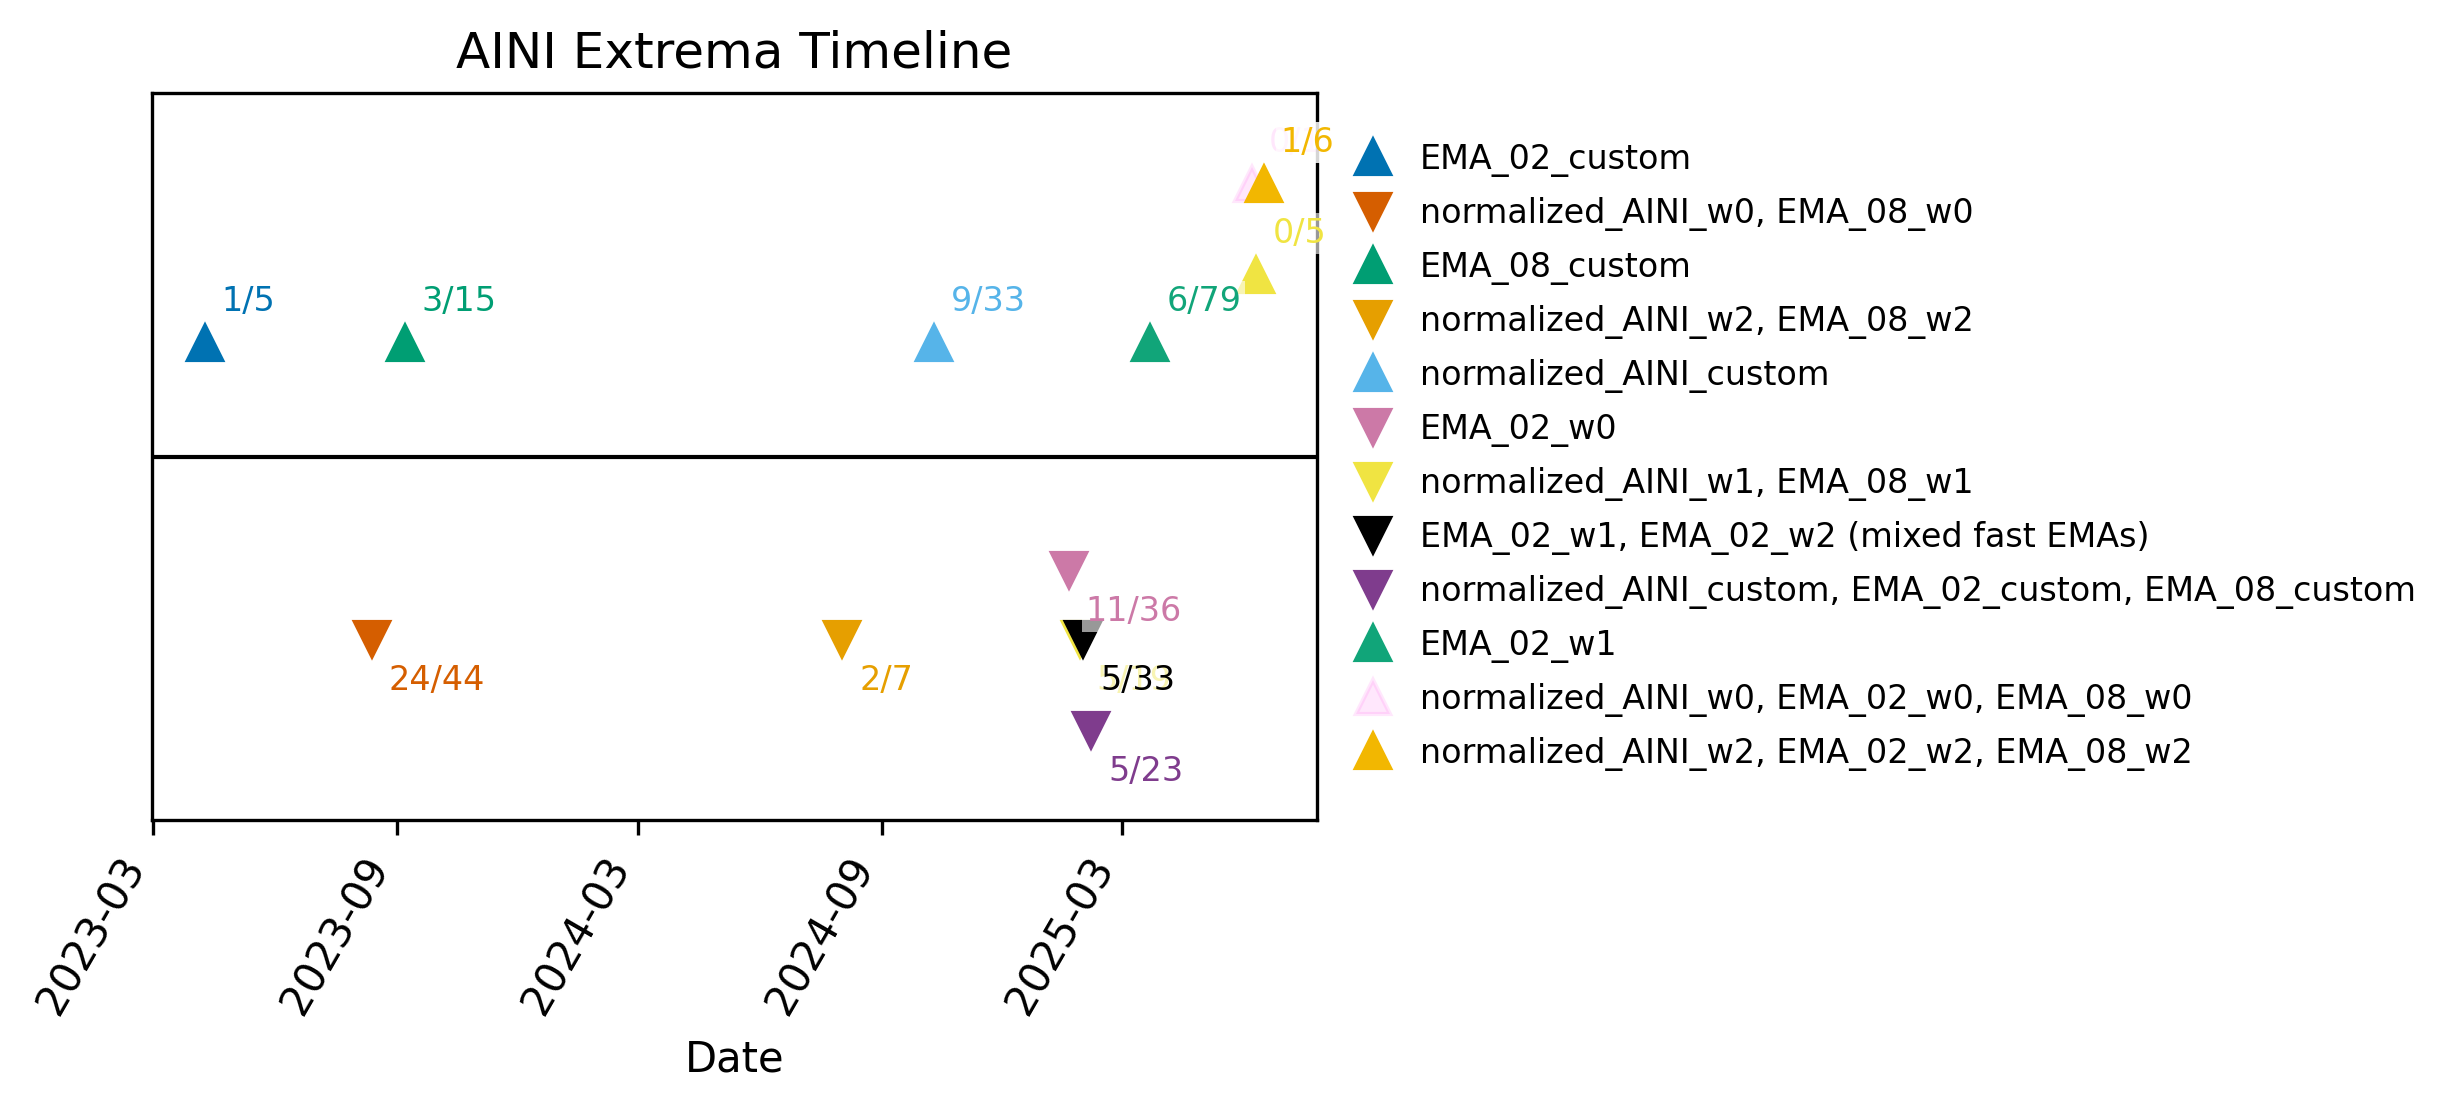

In [ ]:
# investigate distribution via timeline
outpath = fig_path / "extrema_timeline.png"
fig, ax = plot_timeline(
    fractions_min=["24/44", "2/7", "11/36", "5/19", "5/33", "5/23"],
    fractions_max=["1/5", "3/15", "9/33", "6/79", "0/1", "0/5", "1/6"],
    outpath="reports/figures/aini_timeline_with_fractions.png"
)

print(f"Saved: {outpath.resolve()}")

In [ ]:
# unpack subsets into individual dfs

# maxima
art_max_1_w0     = subsets["art_max_1_w0"]      # cutoff: 2025-06-07 | n=3 normalized_AINI_w0, EMA_02_w0, EMA_08_w0
art_max_1_w2     = subsets["art_max_1_w2"]      # cutoff: 2025-06-16 | n=3 normalized_AINI_w2, EMA_02_w2, EMA_08_w2
art_max_2_w1     = subsets["art_max_2_w1"]      # cutoff: 2025-06-10 | n=2 normalized_AINI_w1, EMA_08_w1
art_max_3_c_norm = subsets["art_max_3_c_norm"]  # cutoff: 2024-10-10 | n=1 normalized_AINI_custom
art_max_3_c_02   = subsets["art_max_3_c_02"]    # cutoff: 2023-04-09 | n=1 EMA_02_custom
art_max_3_c_08   = subsets["art_max_3_c_08"]    # cutoff: 2023-09-07 | n=1 EMA_08_custom
art_max_3_w1_02  = subsets["art_max_3_w1_02"]   # cutoff: 2025-03-22 | n=1 EMA_02_w1

# minima
art_min_1_custom = subsets["art_min_1_custom"]  # cutoff: 2025-02-06 | n=3 normalized_AINI_custom, EMA_02_custom, EMA_08_custom
art_min_2_w0     = subsets["art_min_2_w0"]      # cutoff: 2023-08-13 | n=2 normalized_AINI_w0, EMA_08_w0
art_min_2_w1     = subsets["art_min_2_w1"]      # cutoff: 2025-01-28 | n=2 normalized_AINI_w1, EMA_08_w1
art_min_2_w2     = subsets["art_min_2_w2"]      # cutoff: 2024-08-02 | n=2 normalized_AINI_w2, EMA_08_w2
art_min_2_w1_w2  = subsets["art_min_2_w1_w2"]   # cutoff: 2025-01-31 | n=2 EMA_02_w1, EMA_02_w2 (mixed only)
art_min_3_w0_02  = subsets["art_min_3_w0_02"]   # cutoff: 2025-01-20 | n=1 EMA_02_w0



In [ ]:
# maxima according to window size = 0
read(art_max_1_w0)

Date       : 2025-06-07 00:00:00
Article ID : 20253907
Hype       : w0=1.000, w1=0.000, w2=0.000, c=-1.000
--------------------------------------------------------------------------------
[ai_window]
ai and crypto czar, has been privately encouraging.
--------------------------------------------------------------------------------
[ai_window_c]
photo : andrew leyden / zuma press behind the scenes, some people close to trump and musk have
sought to organize a phone call between the two men in an attempt to hash out their differences,
according to people familiar with the matter. david sacks, a venture capitalist who acts as trump ’
s ai and crypto czar, has been privately encouraging musk to call the president to try to mend the
relationship, according to people familiar with the matter. james fishback, a businessman and
supporter of both trump and musk, encouraged musk on social media to apologize to the president. a
spokeswoman for sacks declined to comment.
--------------------------

In [ ]:
# maxima according to window size = 2
read(art_max_1_w2)

Date       : 2025-06-16 00:00:00
Article ID : 20254115
Hype       : w0=1.000, w1=1.000, w2=1.000, c=0.000
--------------------------------------------------------------------------------
[ai_window]
gpus and. ai investments and a need for debt funding could pose risks,. ai infrastructure, as
spending is expected to grow 4 in compared with 65 in. ai event that it can meet surging demand for
artificial - intelligence hardware, showcasing upcoming product launches that aim to position the
company as a realistic alternative to. ai development, self - sufficiency, and global expansion,
among others.
--------------------------------------------------------------------------------
[ai_window_c]
shopify has historically grown its merchant base in times of significant disruption, including 2008,
the covid - 19 pandemic and brexit, showing the company ’ s growing role as a key strategic partner
for merchants, the analysts say. ( kelly. cloonan @ wsj. com ) 1415 et – piper sandler says advanced
m

In [ ]:
# maxima according normalized_AINI_w1, EMA_08_w1
read(art_max_2_w1)

Date       : 2025-06-10 00:00:00
Article ID : 20253954
Hype       : w0=0.000, w1=0.000, w2=1.000, c=-1.000
--------------------------------------------------------------------------------
[ai_window]
google extends employee buyout offers in push to raise ai spending u. s. employees across multiple
divisions offered chance to leave with severance. ai competitors. ai spending. the company has for
years been culling workers as it invests tens of billions of dollars to develop cutting - edge
artificial intelligence models and systems. ai competitors that threaten to erode its search
dominance. ai and other growth areas with the cost discipline needed to fund those activities. ai
race,. ai model and chatbot, known as. ai features to many of its products. u. s. introduction of "
ai.
--------------------------------------------------------------------------------
[ai_window_c]
title : google extends employee buyout offers in push to raise ai spending technology artificial
intelligence follow 

In [ ]:
# minima according to custom FinBERT
read(art_min_1_custom) # scraping issue

Date       : 2025-02-06 00:00:00
Article ID : 20251056
Hype       : w0=-1.000, w1=0.000, w2=1.000, c=-1.000
--------------------------------------------------------------------------------
[ai_window]
tech giants double down on their massive ai spending amazon,. meta pour billions into artificial
intelligence, undeterred by. ai.
--------------------------------------------------------------------------------
[ai_window_c]
title : tech giants double down on their massive ai spending technology artificial intelligence
follow tech giants double down on their massive ai spending amazon, google, microsoft and meta pour
billions into artificial intelligence, undeterred by deepseek ’ s rise save listen ( 2 min ) capital
spending, quarterly $ 75 billion meta 50 alphabet microsoft 25 amazon 0 2020 ’ 21 ’ 22 ’ 23 ’ 24
note : data in this chart and those below reflect purchases of property and equipment. this chart
shows data for each calendar quarter. microsoft ’ s fiscal year ends june 30. sour

In [ ]:
# minima according to ["art_min_2_w1"]   # cutoff: 2025-01-28 | n=2 normalized_AINI_w1, EMA_08_w1
read(art_min_2_w1) 

Date       : 2025-01-28 00:00:00
Article ID : 2025720
Hype       : w0=-1.000, w1=-1.000, w2=-1.000, c=0.000
--------------------------------------------------------------------------------
[ai_window]
referring to the impact of artificial intelligence,. the new pope is making artificial intelligence
a signature issuebut. an. ai companion is just a phone call away for residents of this senior living
communityand their mental health is improving as a result. ai. ai, researchers argue that
fundamental flaws in reasoning models mean bots aren ' t on the verge of exceeding human smarts.
--------------------------------------------------------------------------------
[ai_window_c]
you ' ve run out of free articles. subscribe for unlimited access. subscribe now what to read next
technology amazon ceo says ai will lead to smaller workforce june 17, 2025 referring to the impact
of artificial intelligence, andy jassy tells employees, “ we expect that this will reduce our total
corporate workforc

Manual investigate unclear articles

In [ ]:
# extract full corpus; investigated: 20253960; 20253982; 202415542; 20251095; 20251069; 2025720
corpus_text = w0_df.loc[w0_df["article_id"] == 2025720, "corpus"].iloc[0]
title = w0_df.loc[w0_df["article_id"] == 2025720, "title"].iloc[0]

print("TITLE:", title)
print("\nCORPUS:\n")
print(corpus_text)

TITLE: Sony Group Names COO Hiroki Totoki as New Chief Executive

CORPUS:

TECHNOLOGY
Sony Group Names COO Hiroki Totoki as New Chief Executive
Lin Tao will become the group’s new chief financial officer
By
Kosaku Narioka
Follow
Updated Jan. 28, 2025 10:01 pm ET
Save
Listen
(1 min)
PHOTO: JUSTIN SULLIVAN/GETTY IMAGES
Sony Group 6758 0.85%
increase; green up pointing triangle
said Chief Operating Officer Hiroki Totoki, who has led the company’s growth in entertainment content, would become chief executive on April 1.
The Japanese entertainment and electronics company said Wednesday that Lin Tao, who currently serves as senior vice president for finance at videogame unit Sony Interactive Entertainment, would become the group’s new chief financial officer.
You've run out of free articles.
Subscribe for unlimited access.
Subscribe Now
What to Read Next
TECHNOLOGY
Amazon CEO Says AI Will Lead to Smaller Workforce
June 17, 2025
Referring to the impact of artificial intelligence, Andy Jassy t

In [ ]:
# time series vs. AINI
fin_path = root / "data" / "raw" / "financial"
fin_data = pd.read_csv(fin_path / "full_daily_2023_2025.csv")

# verify
print(fin_data.head())

         Date Ticker       Open       High        Low      Close  Adj Close  \
0  2023-04-03   ROBO  54.439999  54.639999  54.148998  54.599998  54.278755   
1  2023-04-04   ROBO  54.599998  54.599998  53.849998  54.060001  53.741936   
2  2023-04-05   ROBO  53.509998  53.509998  52.730000  52.939999  52.628521   
3  2023-04-06   ROBO  52.540001  52.799999  52.209999  52.689999  52.379993   
4  2023-04-10   ROBO  52.279999  53.099998  52.180000  53.040001  52.727932   

   Volume  
0  132600  
1  257500  
2  169700  
3  198600  
4  237700  


In [ ]:
# ensure data format
fin_data["date"] = pd.to_datetime(fin_data["Date"])
m["date"] = pd.to_datetime(m["date"])

# merge financial data and AINI
aini_fin = pd.merge(fin_data,m,how="left",on="date")

# verifiy
aini_fin.columns

Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'date', 'normalized_AINI_w0', 'EMA_02_w0', 'EMA_08_w0',
       'normalized_AINI_w1', 'EMA_02_w1', 'EMA_08_w1', 'normalized_AINI_w2',
       'EMA_02_w2', 'EMA_08_w2', 'normalized_AINI_custom', 'EMA_02_custom',
       'EMA_08_custom', 'n_articles', 'year', 'w0_mean', 'w1_mean', 'w2_mean',
       'c_mean'],
      dtype='object')

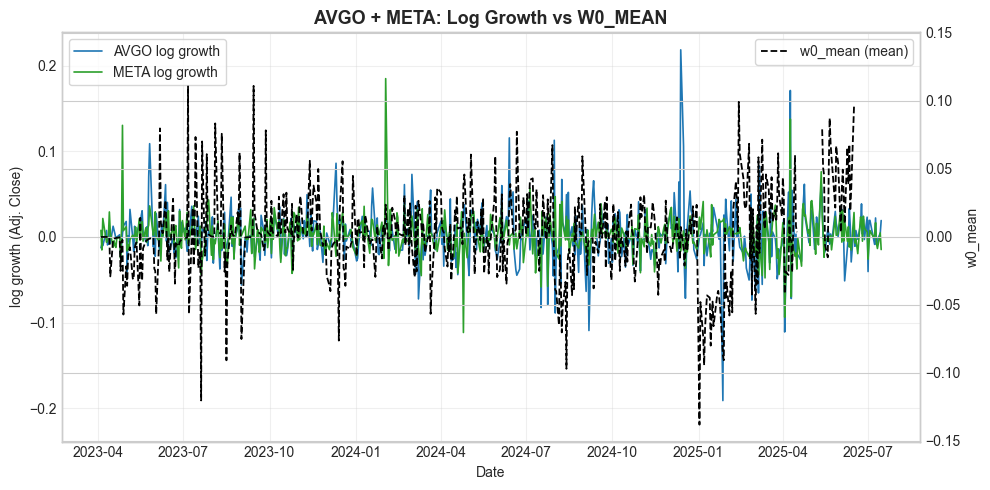

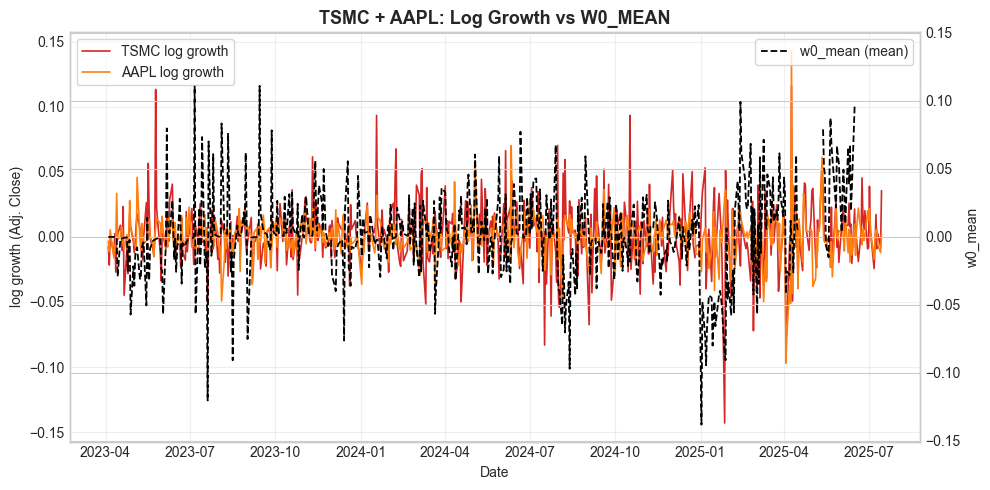

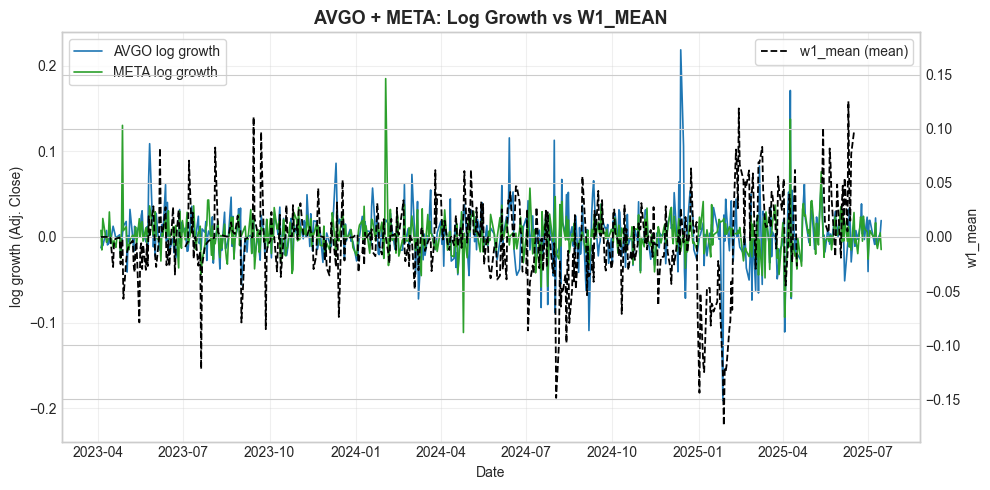

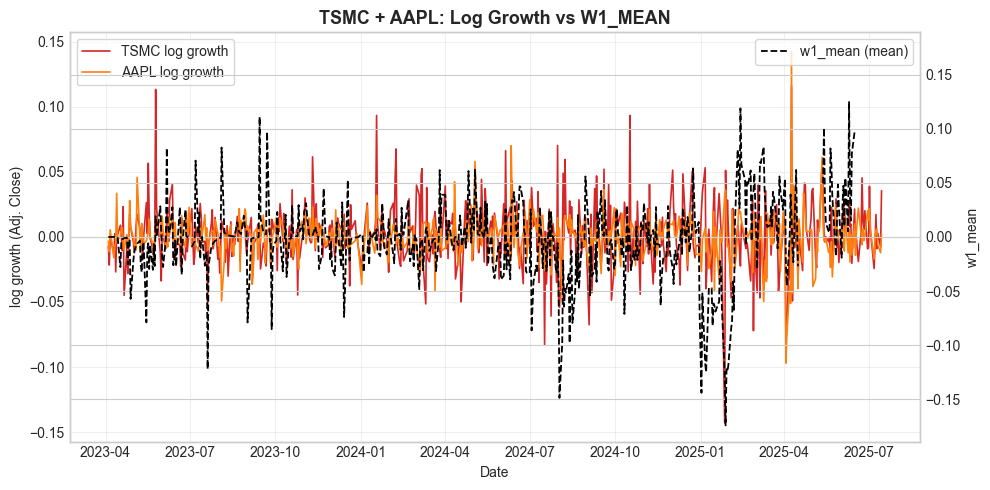

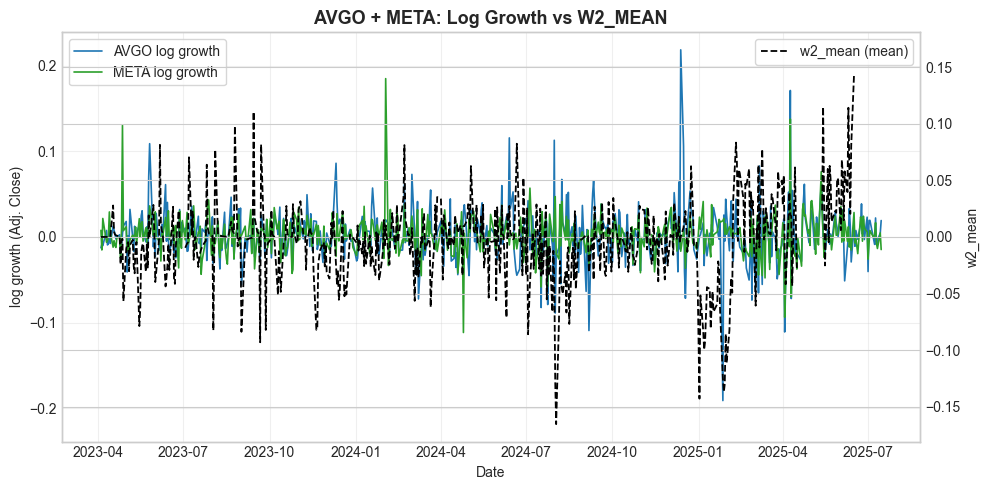

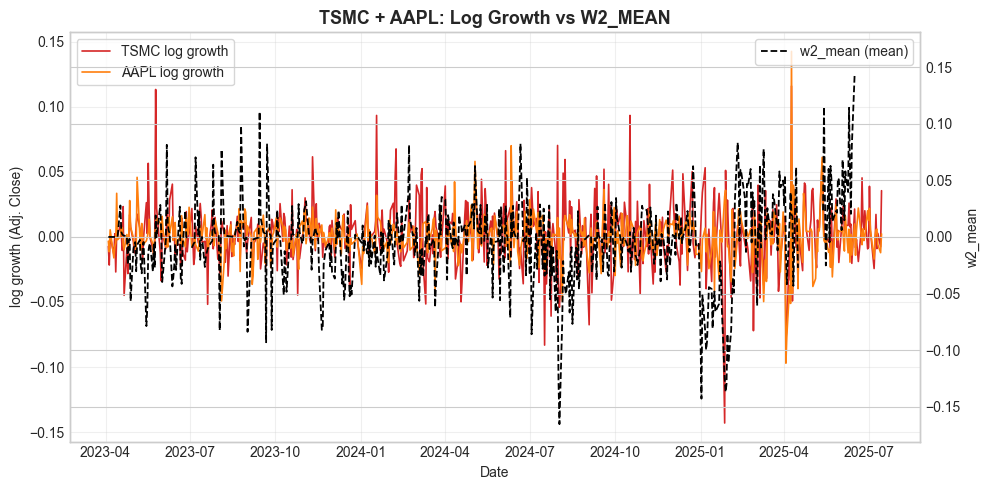

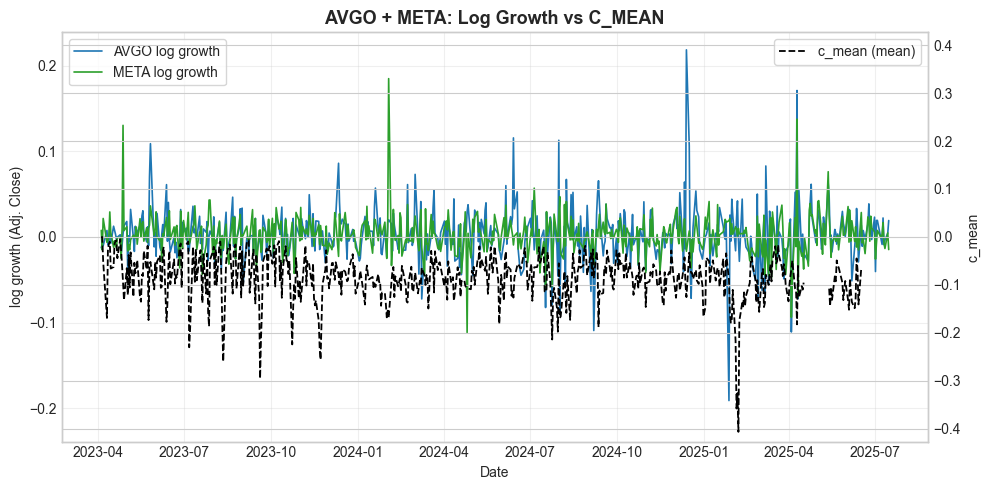

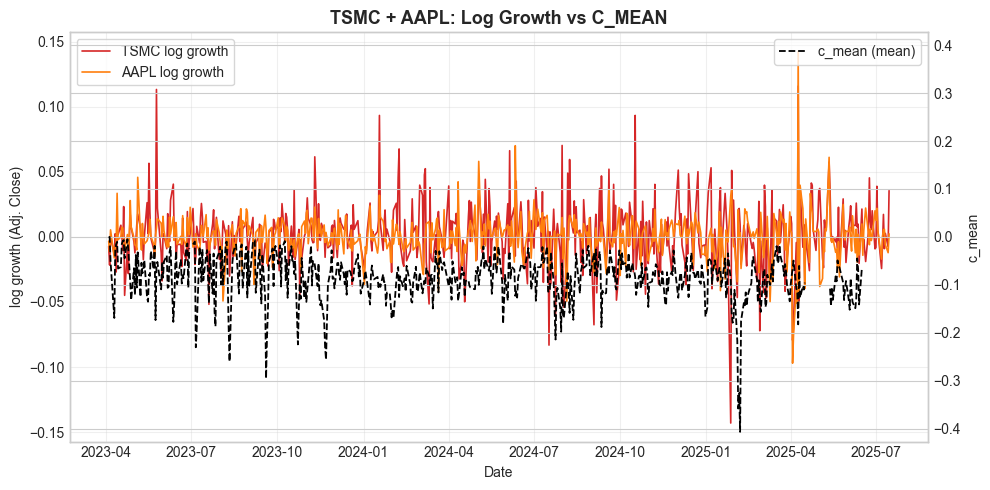

In [ ]:
#  prep
df = aini_fin.copy()
df['Date'] = pd.to_datetime(df['Date'])

# Handle ticker naming
tickers = ['AVGO', 'META', 'TSM', 'APPL']
if 'APPL' not in df['Ticker'].unique() and 'AAPL' in df['Ticker'].unique():
    tickers[tickers.index('APPL')] = 'AAPL'
rename_map = {'TSM': 'TSMC'}
df['Ticker_display'] = df['Ticker'].replace(rename_map)

# Compute log growth
df = df.sort_values(['Ticker', 'Date'])
df['log_growth'] = df.groupby('Ticker')['Adj Close'].transform(lambda s: np.log(s).diff())

# Keep only relevant tickers
df = df[df['Ticker'].isin(tickers)].dropna(subset=['log_growth'])

# Define AINI means
mean_cols = ['w0_mean', 'w1_mean', 'w2_mean', 'c_mean']

# Define ticker groups
groups = {
    "AVGO + META": ['AVGO', 'META'],
    "TSMC + AAPL": ['TSM', 'AAPL']  # TSM shown as TSMC
}

colors = {
    'AVGO': 'tab:blue',
    'META': 'tab:green',
    'TSM': 'tab:red',
    'TSMC': 'tab:red',
    'AAPL': 'tab:orange'
}

plt.style.use('seaborn-v0_8-whitegrid')

# plotting
for mean_col in mean_cols:
    for group_name, group_tickers in groups.items():
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax2 = ax1.twinx()

        for t in group_tickers:
            disp = rename_map.get(t, t)
            d = df[df['Ticker'] == t]
            ax1.plot(d['Date'], d['log_growth'], label=f"{disp} log growth", linewidth=1.2, color=colors.get(t, 'black'))

        # plot mean AINI across those tickers (right y-axis)
        mean_series = (
            df[df['Ticker'].isin(group_tickers)]
            .groupby('Date')[mean_col]
            .mean()
        )
        ax2.plot(mean_series.index, mean_series.values,
                 color='black', linestyle='--', linewidth=1.3, label=f"{mean_col} (mean)")

        # center both axes around 0
        ylims1 = ax1.get_ylim()
        ylims2 = ax2.get_ylim()
        lim1 = max(abs(ylims1[0]), abs(ylims1[1]))
        lim2 = max(abs(ylims2[0]), abs(ylims2[1]))
        ax1.set_ylim(-lim1, lim1)
        ax2.set_ylim(-lim2, lim2)

        ax1.set_title(f"{group_name}: Log Growth vs {mean_col.upper()}", fontsize=13, fontweight='bold')
        ax1.set_xlabel("Date")
        ax1.set_ylabel("log growth (Adj. Close)")
        ax2.set_ylabel(mean_col)
        ax1.legend(loc='upper left', frameon=True)
        ax2.legend(loc='upper right', frameon=True)
        ax1.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


In [ ]:
# analyze financial means
fin_data.columns
fin_data

Date Ticker         Open         High          Low        Close  \
0     2023-04-03   ROBO    54.439999    54.639999    54.148998    54.599998   
1     2023-04-04   ROBO    54.599998    54.599998    53.849998    54.060001   
2     2023-04-05   ROBO    53.509998    53.509998    52.730000    52.939999   
3     2023-04-06   ROBO    52.540001    52.799999    52.209999    52.689999   
4     2023-04-10   ROBO    52.279999    53.099998    52.180000    53.040001   
...          ...    ...          ...          ...          ...          ...   
9719  2025-07-09  ^GSPC  6243.330078  6269.160156  6231.430176  6263.259766   
9720  2025-07-10  ^GSPC  6266.799805  6290.220215  6251.439941  6280.459961   
9721  2025-07-11  ^GSPC  6255.680176  6269.439941  6237.600098  6259.750000   
9722  2025-07-14  ^GSPC  6255.149902  6273.310059  6239.220215  6268.560059   
9723  2025-07-15  ^GSPC  6295.290039  6302.040039  6241.680176  6243.759766   

        Adj Close      Volume       date  
0       54.278755      132600 2023-04-03  
1       53.741936      257500 2023-04-04  
2       52.628521      169700 2023-04-05  
3       52.379993      198600 2023-04-06  
4       52.727932      237700 2023-04-10  
...           ...         ...        ...  
9719  6263.259766  4813340000 2025-07-09  
9720  6280.459961  5367350000 2025-07-10  
9721  6259.750000  4656210000 2025-07-11  
9722  6268.560059  4722250000 2025-07-14  
9723  6243.759766  5133670000 2025-07-15  

[9724 rows x 9 columns]

In [ ]:
# sort by Ticker, date to ensure order
fin_data = fin_data.sort_values(['Ticker', 'date'])

# extract year
fin_data['year'] = fin_data['date'].dt.year

# rebase Adj Close for each ticker so that the first value = 100
fin_data['Adj_Close_Index'] = (
    fin_data.groupby('Ticker')['Adj Close']
    .apply(lambda x: (x / x.iloc[0]) * 100)
    .reset_index(level=0, drop=True)
)

# Compute first and last value per Ticker-Year combination
yearly_growth = (
    fin_data.groupby(['Ticker', 'year'])['Adj_Close_Index']
    .agg(['first', 'last'])
    .reset_index()
)

# Calculate yearly growth in %
yearly_growth['yearly_growth_%'] = (yearly_growth['last'] / yearly_growth['first'] - 1) * 100

# compute total growth 
total_growth = (
    fin_data.groupby('Ticker')['Adj_Close_Index']
    .agg(first='first', last='last')
    .reset_index()
)

total_growth['total_growth_%'] = (total_growth['last'] / total_growth['first'] - 1) * 100

# merge yearly and total growths 
result = yearly_growth.merge(total_growth[['Ticker', 'total_growth_%']], on='Ticker', how='left')

# Show final result
print(result)

   Ticker  year       first        last  yearly_growth_%  total_growth_%
0    AAPL  2023  100.000000  116.333284        16.333284       27.276781
1    AAPL  2024  112.170091  152.053698        35.556364       27.276781
2    AAPL  2025  148.064442  127.276781       -14.039604       27.276781
3     AIQ  2023  100.000000  127.532681        27.532681       79.579802
4     AIQ  2024  124.505931  158.281424        27.127617       79.579802
5     AIQ  2025  157.544084  179.579802        13.987017       79.579802
6     AMD  2023  100.000000  152.661565        52.661565       61.153692
7     AMD  2024  143.516990  125.093210       -12.837351       61.153692
8     AMD  2025  124.927507  161.153692        28.997765       61.153692
9    AMZN  2023  100.000000  148.364415        48.364415      121.023336
10   AMZN  2024  146.401706  214.227118        46.328293      121.023336
11   AMZN  2025  215.037587  221.023336         2.783582      121.023336
12   ARKQ  2023  100.000000  116.377569        16.3

In [ ]:
# cosntruct same variables for S&P 500
sp500 = pd.read_csv(fin_path / "^GSPC_full_2023_2025.csv")


In [ ]:
# ensure date format
sp500["date"] = pd.to_datetime(sp500["Date"])

# Sort by date
sp500 = sp500.sort_values('date').reset_index(drop=True)

# Extract year
sp500['year'] = sp500['date'].dt.year

# Rebase Adj Close so that the first value = 100
sp500['Adj_Close_Index'] = sp500['Adj Close'] / sp500['Adj Close'].iloc[0] * 100

# Compute first and last value per Year
yearly_growth = (
    sp500.groupby('year', as_index=False)['Adj_Close_Index']
         .agg(first='first', last='last')
)

# Yearly growth in %
yearly_growth['yearly_growth_%'] = (yearly_growth['last'] / yearly_growth['first'] - 1) * 100

# Total growth over the whole sample
total_growth_pct = (sp500['Adj_Close_Index'].iloc[-1] / sp500['Adj_Close_Index'].iloc[0] - 1) * 100
yearly_growth['total_growth_%'] = total_growth_pct

# Final result
yearly_growth



year       first        last  yearly_growth_%  total_growth_%
0  2023  100.000000  115.645988        15.645988       51.381864
1  2024  114.991365  142.601914        24.010976       51.381864
2  2025  142.284784  151.381864         6.393572       51.381864

In [57]:
# Load data
fin_cus = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_on_binary.csv")
fin_w0  = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_0.csv")
fin_w1  = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_1.csv")
fin_w2  = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_2.csv")

# Assign suffixes
dfs = {
    "custom": fin_cus,
    "w0": fin_w0,
    "w1": fin_w1,
    "w2": fin_w2
}

# Add suffixes (except the join key)
for name, df in dfs.items():
    df.columns = [col if col == "article_id" else f"{col}_{name}" for col in df.columns]

# Merge all on 'article_id'
merged = reduce(lambda left, right: pd.merge(left, right, on="article_id", how="inner"), dfs.values())

# Inspect
print(merged.shape)
print(merged.columns)



(13425, 70)
Index(['article_id', 'image_src_custom', 'scanned_time_custom', 'title_custom',
       'sub_title_custom', 'corpus_custom', 'index_id_custom', 'id_custom',
       'date_custom', 'link_custom', 'section_custom', 'cleaned_corpus_custom',
       'ai_window_custom', 'predicted_label_custom', 'predicted_class_custom',
       'ai_relevant_custom', 'sentiment_label_custom',
       'sentiment_score_custom', 'hype_score_custom', 'image_src_w0',
       'scanned_time_w0', 'title_w0', 'sub_title_w0', 'corpus_w0',
       'index_id_w0', 'id_w0', 'date_w0', 'link_w0', 'section_w0',
       'cleaned_corpus_w0', 'text_w0', 'ai_window_w0', 'ai_relevant_w0',
       'sentiment_label_w0', 'sentiment_score_w0', 'hype_score_w0',
       'image_src_w1', 'scanned_time_w1', 'title_w1', 'sub_title_w1',
       'corpus_w1', 'index_id_w1', 'id_w1', 'date_w1', 'link_w1', 'section_w1',
       'cleaned_corpus_w1', 'text_w1', 'ai_window_w1', 'ai_relevant_w1',
       'sentiment_label_w1', 'sentiment_score_w1',

In [58]:
# cols to keep 
cols = ["article_id","link_custom","date","title_custom","cleaned_corpus_custom","ai_window_custom","ai_window_w0","ai_window_w1","ai_window_w2","hype_score_custom","hype_score_w0","hype_score_w1","hype_score_w2"]

# ensure data consistency
merged["date"] = pd.to_datetime(merged["date_custom"])

# subset for relevant collumns
merged_sub = merged[cols]



merged_sub

article_id                                        link_custom  \
0       202413068  https://www.wsj.com/business/telecom/baidu-ter...   
1       202413069  https://www.wsj.com/opinion/military-extremist...   
2       202413070  https://www.wsj.com/opinion/double-dipping-in-...   
3       202413071  https://www.wsj.com/opinion/xi-jinping-says-ha...   
4       202413072  https://www.wsj.com/world/middle-east/israel-r...   
...           ...                                                ...   
13420   202437453  https://www.wsj.com/business/entrepreneurship/...   
13421   202437457  https://www.wsj.com/politics/policy/kamala-har...   
13422   202437458  https://www.wsj.com/politics/elections/donald-...   
13423   202437459  https://www.wsj.com/politics/policy/trump-fore...   
13424   202437460  https://www.wsj.com/world/middle-east/qatar-te...   

            date                                       title_custom  \
0     2024-01-01  Baidu Terminates $3.6B Deal to Buy JOYY’s Chin...   
1     2024-01-01                The Military’s Phantom ‘Extremists’   
2     2024-01-01                  Double Dipping in Opioid Lawsuits   
3     2024-01-01                     Xi Jinping Says Happy New Year   
4     2024-01-01  Israel Reshuffles Forces, Prepares for Long-Te...   
...          ...                                                ...   
13420 2024-08-27  Leonard Riggio, Who Built Barnes & Noble Into ...   
13421 2024-08-27  Kamala Harris’s Tax Increases and Cuts Take Shape   
13422 2024-11-09  With Arizona and Nevada Calls for Trump, Full ...   
13423 2024-11-09  Deals and Deterrence: Trump’s Foreign Policy i...   
13424 2024-11-09  Qatar Pauses Efforts to Mediate Stalled Gaza C...   

                                   cleaned_corpus_custom ai_window_custom  \
0      Jan. 1, 644 pm. ET 2 min. As of the end of. De...              NaN   
1      REVIEW. OUTLOOK. Jan. 1, 545 pm. ET 834 3 min....              NaN   
2      REVIEW. OUTLOOK. OptumRx seeks to disqualify. ...              NaN   
3      REVIEW. OUTLOOK. China's leader tries to influ...              NaN   
4      Israel. Reshuffles. Forces,. Prepares for. Lon...              NaN   
...                                                  ...              ...   
13420  Leonard. Riggio,. Who. Built. Barnes. Noble. I...              NaN   
13421  Kamala. Harris's. Tax. Increases and. Cuts. Ta...              NaN   
13422  With. Arizona and. Nevada. Calls for. Trump,. ...              NaN   
13423  Deals and. Deterrence. Trump's. Foreign. Polic...              NaN   
13424  Qatar. Pauses. Efforts to. Mediate. Stalled. G...              NaN   

      ai_window_w0 ai_window_w1 ai_window_w2  hype_score_custom  \
0              NaN          NaN          NaN                  0   
1              NaN          NaN          NaN                  0   
2              NaN          NaN          NaN                  0   
3              NaN          NaN          NaN                  0   
4              NaN          NaN          NaN                  0   
...            ...          ...          ...                ...   
13420          NaN          NaN          NaN                  0   
13421          NaN          NaN          NaN                  0   
13422          NaN          NaN          NaN                  0   
13423          NaN          NaN          NaN                  0   
13424          NaN          NaN          NaN                  0   

       hype_score_w0  hype_score_w1  hype_score_w2  
0                  0              0              0  
1                  0              0              0  
2                  0              0              0  
3                  0              0              0  
4                  0              0              0  
...              ...            ...            ...  
13420              0              0              0  
13421              0              0              0  
13422              0              0              0  
13423              0         

In [ ]:
def display_article_windows(merged_sub: pd.DataFrame, article_id):
    df = merged_sub  

    # robust match 
    mask = df["article_id"].astype(str) == str(article_id)
    if not mask.any():
        display(HTML(f"<b style='color:red'>No entry found for article_id = {article_id}</b>"))
        return None

    row = df.loc[mask].iloc[0]

    cols = [
        ('custom', 'ai_window_custom', 'hype_score_custom'),
        ('w0', 'ai_window_w0', 'hype_score_w0'),
        ('w1', 'ai_window_w1', 'hype_score_w1'),
        ('w2', 'ai_window_w2', 'hype_score_w2'),
    ]

    data = []
    for label, ai_col, hype_col in cols:
        snippet = str(row.get(ai_col, "")) if pd.notna(row.get(ai_col, None)) else ""
        hype = row.get(hype_col, "")
        data.append({
            "Model": f"<b>{label}</b>",
            "AI Window Snippet": snippet.replace("\n", "<br>"),
            "Hype Score": hype
        })

    out = pd.DataFrame(data)

    # HTML table with clean formatting
    html_table = out.to_html(escape=False, index=False).replace(
        '<table border="1" class="dataframe">',
        '<table style="border-collapse:collapse;width:100%;table-layout:fixed;word-wrap:break-word;" border="1">'
    )

    display(HTML(f"<h4>AI Snippets & Hype Scores for article_id = {article_id}</h4>{html_table}"))
    return out

def find_disagreeing_hype_rows(df: pd.DataFrame):
  
    hype_cols = ["hype_score_custom", "hype_score_w0", "hype_score_w1", "hype_score_w2"]

    # ensure numeric comparison (ignore NaN)
    sub = df[hype_cols].apply(pd.to_numeric, errors="coerce")

    # boolean mask: True if at least two non-NaN values differ
    mask = sub.apply(lambda x: x.nunique(dropna=True) > 2, axis=1)

    return df.loc[mask]

disagreeing = find_disagreeing_hype_rows(merged_sub)
print(f"{len(disagreeing)} rows where hype scores disagree.")
disagreeing   

110 rows where hype scores disagree.


article_id                                        link_custom  \
289     202413541  https://www.wsj.com/finance/chip-wars-boost-eu...   
461     202413804  https://www.wsj.com/tech/ai/samsung-kicks-off-...   
465     202413809  https://www.wsj.com/business/earnings/tsmcs-pr...   
790     202414351  https://www.wsj.com/finance/stocks/money-marke...   
950     202414617  https://www.wsj.com/us-news/as-two-nfl-playoff...   
...           ...                                                ...   
12863   202436587  https://www.wsj.com/politics/elections/iran-is...   
13000   202436803  https://www.wsj.com/business/media/paramounts-...   
13060   202436904  https://www.wsj.com/tech/intel-too-big-to-turn...   
13182   202437078  https://www.wsj.com/finance/stocks/the-score-s...   
13381   202437398  https://www.wsj.com/business/c-suite/apple-nam...   

            date                                       title_custom  \
289   2024-01-15  Chip Wars Boost Europe’s Top Tech Company—for Now   
461   2024-01-18                  Samsung Kicks Off AI Upsell Cycle   
465   2024-01-18  TSMC’s Profit Drops on Sluggish Chip Demand, W...   
790   2024-01-24  The Money-Market Bonanza Is Over. So Is Now th...   
950   2024-01-27  As Two NFL Playoff Teams Meet, Their Cities Di...   
...          ...                                                ...   
12863 2024-07-29  Iran Is Working to Undercut Trump in President...   
13000 2024-07-08  Paramount’s Third Act Will Still Offer Plenty ...   
13060 2024-08-10          Intel: Too Big to Turn, Too Vital to Fail   
13182 2024-08-16  The Score: Starbucks, Trump Media, Victoria’s ...   
13381 2024-08-26         Apple’s Top Finance Executive to Step Down   

                                   cleaned_corpus_custom  \
289    MARKETS. FINANCE. Chip. Wars. Boost. Europe's....   
461    Smartphone,. PC makers banking on. AI-enabled ...   
465    3 min. The. Taiwan. Semiconductor. Manufacturi...   
790    MARKETS. FINANCE. Jan. 24, 530 am. ET 304 6 mi...   
950    U.S. As. Two. NFL. Playoff. Teams. Meet,. Thei...   
...                                                  ...   
12863  5 min. Former. President. Donald. Trump speaki...   
13000  Paramount's. Third. Act. Will. Still. Offer. P...   
13060  Intel. Too. Big to. Turn,. Too. Vital to. Fail...   
13182  MARKETS. FINANCE. Aug. 16, 525 pm. ET 2 5 min....   
13381  Apple's. Top. Finance. Executive to. Step. Dow...   

                                        ai_window_custom  \
289    this is very challenging, particularly without...   
461    title : samsung kicks off ai upsell cycle adve...   
465    mike waltz is losing support inside the white ...   
790    when the time horizon was extended to 10 years...   
950    san francisco is still among the top few citie...   
...                                                  ...   
12863  he withdrew from an international agreement in...   
13000  the $ 15 - a - share price tag is a 56 % premi...   
13060  but a big part of intel ’ s current problem is...   
13182  cisco systems cisco announced job cuts and a b...   
13381  photo : marco cantile / lightrocket / getty im...   

                                            ai_window_w0  \
289    dutch company a monopoly on one of the underpi...   
461    samsung kicks off ai upsell cycle smartphone,....   
465                                         ai - driven.   
790    market milestones draw attention and prompt ma...   
950    our path to economic and social renewal requir...   
...                                                  ...   
12863  trump that was serious enough to prompt additi...   
13000                           transformers franchises.   
13060  gpu accelerators, which are key to powering ge...   
13182  cisco cited a need to lower costs and invest i...   
13381  ai capabilities, rather than using external cl...   

                                            ai_window_w1  \
289    asml ' s most advanced competitors have manage...   
461   

In [ ]:
_ = display_article_windows(merged_sub, 202420012)